In [1]:
# SPIKE-AND-SLAB-LASSO

In [ ]:
import torch
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'CUDA version: {torch.version.cuda}')
print(f'Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"}')

In [2]:
pip install pyro-ppl torch pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Complete Variational Bayesian Cox Model with Spike-and-Slab Lasso Priors
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import time

# Configuration
config = {
    "max_epochs": 5000,
    "batch_size": 256,
    "initial_lr": 1e-3,
    "lr_decay": 0.1,
    "decay_step": 1000,
    "clip_norm": 10.0,
    "early_stop_patience": 200,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "precision": torch.float32,
    "log_freq": 100,
    "checkpoint_freq": 500
}

# Set up GPU if available
if config["device"] == "cuda":
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

def load_and_preprocess(path):
    start_time = time.time()
    data = pd.read_csv(path)
    print(f"Data loading time: {time.time()-start_time:.2f}s")
    
    # Extract features and survival data
    X = data.iloc[:, 1:-2].values  # Skip ID, time, event
    time_values = data['time'].values
    event_values = data['event'].values
    
    # Handle missing values and standardize
    X = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-8)
    X = np.nan_to_num(X)
    
    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=config["precision"], device=config["device"])
    time_tensor = torch.tensor(time_values, dtype=config["precision"], device=config["device"])
    event_tensor = torch.tensor(event_values, dtype=config["precision"], device=config["device"])
    
    # Sort by survival time
    sort_idx = torch.argsort(time_tensor)
    return X_tensor[sort_idx], time_tensor[sort_idx], event_tensor[sort_idx]

class CoxPartialLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8
        self.max_exp = 20.0
        
    def forward(self, X_beta, survival_time, event):
        event_mask = event == 1
        n_events = event_mask.sum()
        
        if n_events < 1:
            return torch.tensor(0.0)
        
        # Numerical stability
        X_beta = X_beta - X_beta.max()
        exp_Xb = torch.clamp(X_beta.exp(), max=torch.exp(torch.tensor(self.max_exp)))
        
        # Vectorized computation
        risk_matrix = (survival_time.unsqueeze(0) >= survival_time[event_mask].unsqueeze(1)).float()
        sum_exp = (risk_matrix * exp_Xb.unsqueeze(0)).sum(dim=1)
        log_sum_exp = torch.log(sum_exp + self.eps)
        
        return (X_beta[event_mask] - log_sum_exp).sum() / X_beta.size(0)

def model(X, survival_time, event):
    n, p = X.shape
    alpha = pyro.sample("alpha", dist.Beta(1., 100.))
    
    with pyro.plate("features", p, dim=-1):
        z = pyro.sample("z", dist.Bernoulli(alpha))
        tau = pyro.sample("tau", dist.HalfNormal(0.05))
        theta = pyro.sample("theta", dist.Laplace(0., 1/(tau + 1e-8)))
        beta = z * theta
    
    cox_likelihood = CoxPartialLikelihood()
    log_pl = cox_likelihood(X @ beta, survival_time, event)
    pyro.factor("log_pl", log_pl)

def guide(X, survival_time, event):
    n, p = X.shape
    alpha_a = pyro.param("alpha_a", torch.tensor(1.), constraint=constraints.positive)
    alpha_b = pyro.param("alpha_b", torch.tensor(100.), constraint=constraints.positive)
    pyro.sample("alpha", dist.Beta(alpha_a, alpha_b))
    
    with pyro.plate("features", p, dim=-1):
        q_z = pyro.param("q_z", torch.ones(p)*0.01, constraint=constraints.interval(0., 1.))
        pyro.sample("z", dist.Bernoulli(q_z))
        
        tau_loc = pyro.param("tau_loc", torch.zeros(p))
        tau_scale = pyro.param("tau_scale", torch.ones(p)*0.01, constraint=constraints.positive)
        pyro.sample("tau", dist.LogNormal(tau_loc, tau_scale))
        
        theta_loc = pyro.param("theta_loc", torch.zeros(p))
        theta_scale = pyro.param("theta_scale", torch.ones(p)*0.1, constraint=constraints.positive)
        pyro.sample("theta", dist.Laplace(theta_loc, theta_scale))

def main():
    # Load and prepare data
    data_path = r"D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv"
    X, survival_time, event = load_and_preprocess(data_path)
    
    # Create data loader
    dataset = TensorDataset(X, survival_time, event)
    loader = DataLoader(dataset, 
                      batch_size=config["batch_size"], 
                      shuffle=True,
                      pin_memory=config["device"] == "cuda")
    
    # Initialize model
    pyro.clear_param_store()
    
    # FIX: Use the proper pyro optimizer setup
    optimizer = ClippedAdam({
        "lr": config["initial_lr"],
        "clip_norm": config["clip_norm"],
        "weight_decay": 1e-4
    })
    
    # No need for separate scheduler - pass the optimizer directly to SVI
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1))
    
    # Training setup
    best_loss = float('inf')
    losses = []
    start_time = time.time()
    epoch_times = []
    
    try:
        for epoch in range(config["max_epochs"]):
            epoch_start = time.time()
            total_loss = 0.0
            
            for X_batch, t_batch, e_batch in loader:
                loss = svi.step(X_batch, t_batch, e_batch)
                total_loss += loss
            
            avg_loss = total_loss / len(loader)
            losses.append(avg_loss)
            
            # Manually update learning rate at specific epochs
            if epoch % config["decay_step"] == 0 and epoch > 0:
                current_lr = config["initial_lr"] * (config["lr_decay"] ** (epoch // config["decay_step"]))
                optimizer.set_state({'lr': current_lr})
                print(f"Learning rate decreased to {current_lr:.2e}")
            
            # Early stopping
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience = 0
            else:
                patience += 1
                if patience >= config["early_stop_patience"]:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            # Logging
            epoch_time = time.time() - epoch_start
            epoch_times.append(epoch_time)
            if epoch % config["log_freq"] == 0:
                print(f"Epoch {epoch:04d} | Loss: {avg_loss:.2f} | Time: {epoch_time:.2f}s")
            
            # Checkpointing
            if epoch % config["checkpoint_freq"] == 0 and epoch > 0:
                checkpoint = {
                    'epoch': epoch,
                    'losses': losses,
                    'params': pyro.get_param_store().get_state()
                }
                torch.save(checkpoint, f"checkpoint_epoch_{epoch}.pt")
                
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    
    # Final output
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/3600:.2f} hours")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    # Save final model
    final_state = {
        'params': pyro.get_param_store().get_state(),
        'losses': losses,
        'config': config
    }
    torch.save(final_state, "final_model.pt")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(losses)
    plt.title("Training Loss (Negative ELBO)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("training_loss.png")
    plt.show()
    
    # Feature analysis
    q_z = pyro.param("q_z").detach().cpu().numpy()
    theta_loc = pyro.param("theta_loc").detach().cpu().numpy()
    posterior_means = q_z * theta_loc
    
    print("\nTop 10 Features:")
    top_idx = np.argsort(-q_z)[:10]
    for i, idx in enumerate(top_idx):
        print(f"{i+1:2d}. Feature {idx:4d} | Prob: {q_z[idx]:.4f} | Coef: {posterior_means[idx]:.6f}")

if __name__ == "__main__":
    main()

Data loading time: 0.22s


RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

In [4]:
# more visualizations

Data loading time: 0.20s
Epoch 0000 | Loss: 201203.15 | Time: 0.04s
Epoch 0100 | Loss: 91782.58 | Time: 0.04s
Epoch 0200 | Loss: 42617.45 | Time: 0.05s
Epoch 0300 | Loss: 20690.76 | Time: 0.05s
Epoch 0400 | Loss: 10917.30 | Time: 0.05s
Epoch 0500 | Loss: 6859.95 | Time: 0.04s
Epoch 0600 | Loss: 5227.39 | Time: 0.05s
Epoch 0700 | Loss: 4164.12 | Time: 0.05s
Epoch 0800 | Loss: 3358.21 | Time: 0.06s
Epoch 0900 | Loss: 2667.94 | Time: 0.04s
Learning rate decreased to 1.00e-04
Epoch 1000 | Loss: 2087.76 | Time: 0.05s
Epoch 1100 | Loss: 1597.86 | Time: 0.04s
Epoch 1200 | Loss: 1261.55 | Time: 0.03s
Epoch 1300 | Loss: 1084.04 | Time: 0.04s
Epoch 1400 | Loss: 1028.42 | Time: 0.05s
Epoch 1500 | Loss: 996.26 | Time: 0.03s
Epoch 1600 | Loss: 1037.54 | Time: 0.06s
Epoch 1700 | Loss: 1038.40 | Time: 0.03s
Early stopping at epoch 1764

Training completed in 0.02 hours
Average epoch time: 0.04s


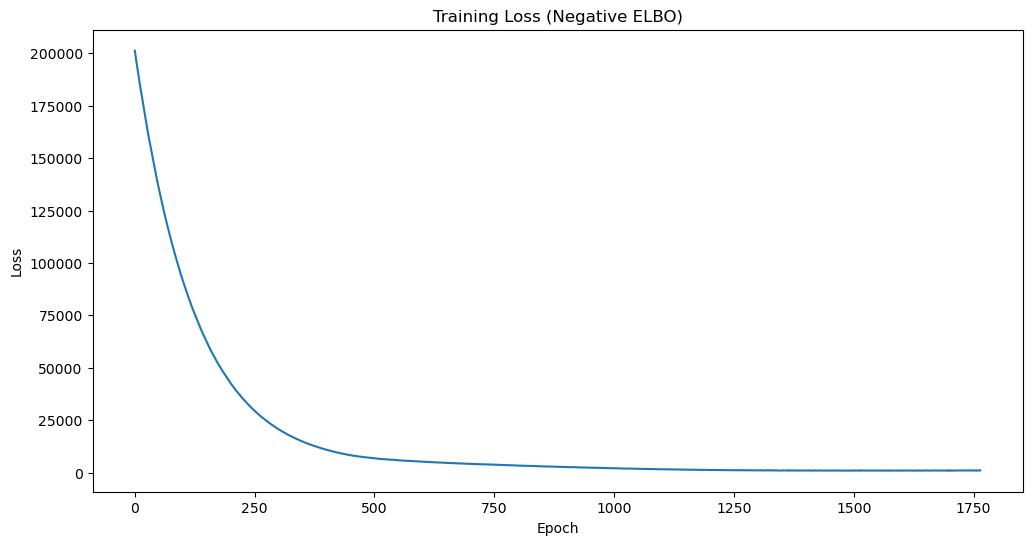


Top 10 Features:
 1. Feature  418 | Prob: 0.3618 | Coef: -0.008205
 2. Feature  653 | Prob: 0.3563 | Coef: 0.054447
 3. Feature  847 | Prob: 0.3542 | Coef: 0.011081
 4. Feature  270 | Prob: 0.3541 | Coef: -0.021383
 5. Feature  423 | Prob: 0.3540 | Coef: -0.006755
 6. Feature  420 | Prob: 0.3536 | Coef: -0.061419
 7. Feature  169 | Prob: 0.3513 | Coef: 0.003790
 8. Feature  360 | Prob: 0.3499 | Coef: 0.044806
 9. Feature  100 | Prob: 0.3484 | Coef: -0.004839
10. Feature  990 | Prob: 0.3476 | Coef: 0.000984

Concordance Index (C-Index): 0.6629


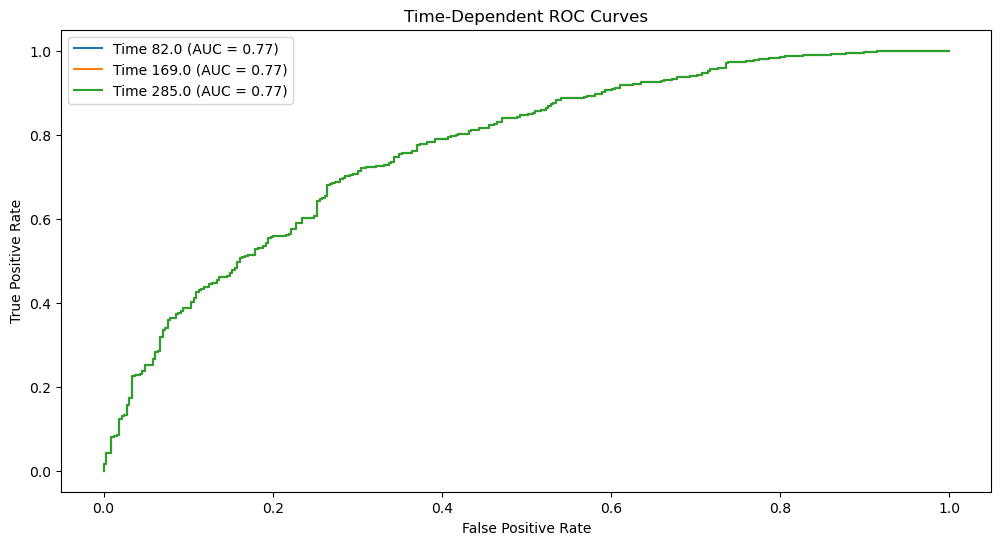

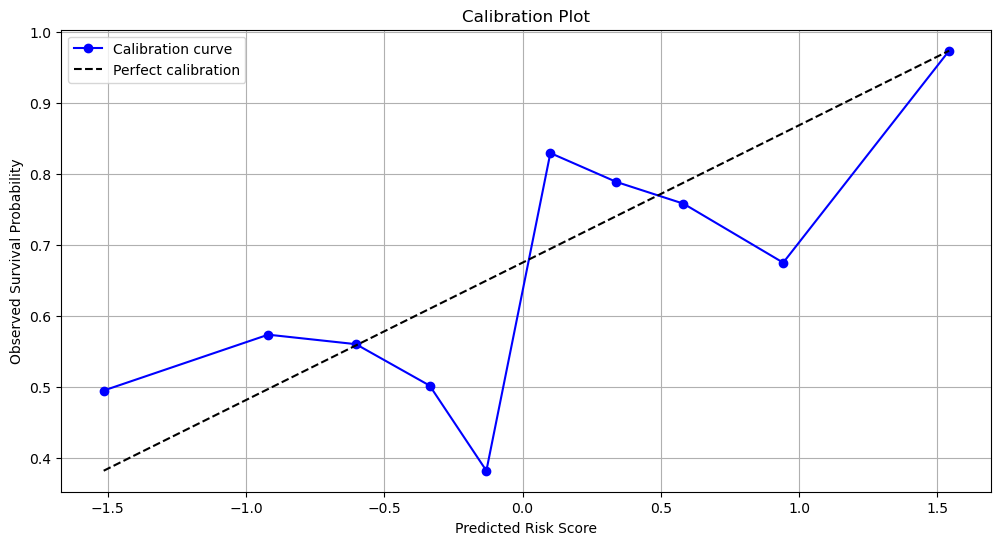

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from lifelines.utils import concordance_index
from sklearn.metrics import roc_curve, auc
from lifelines import KaplanMeierFitter
import time

# Configuration
config = {
    "max_epochs": 5000,
    "batch_size": 256,
    "initial_lr": 1e-3,
    "lr_decay": 0.1,
    "decay_step": 1000,
    "clip_norm": 10.0,
    "early_stop_patience": 200,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "precision": torch.float32,
    "log_freq": 100,
    "checkpoint_freq": 500
}

# Set up GPU if available
if config["device"] == "cuda":
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

def load_and_preprocess(path):
    start_time = time.time()
    data = pd.read_csv(path)
    print(f"Data loading time: {time.time()-start_time:.2f}s")
    
    # Extract features and survival data
    X = data.iloc[:, 1:-2].values  # Skip ID, time, event
    time_values = data['time'].values
    event_values = data['event'].values
    
    # Handle missing values and standardize
    X = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-8)
    X = np.nan_to_num(X)
    
    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=config["precision"], device=config["device"])
    time_tensor = torch.tensor(time_values, dtype=config["precision"], device=config["device"])
    event_tensor = torch.tensor(event_values, dtype=config["precision"], device=config["device"])
    
    # Sort by survival time
    sort_idx = torch.argsort(time_tensor)
    return X_tensor[sort_idx], time_tensor[sort_idx], event_tensor[sort_idx]

class CoxPartialLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8
        self.max_exp = 20.0
        
    def forward(self, X_beta, survival_time, event):
        event_mask = event == 1
        n_events = event_mask.sum()
        
        if n_events < 1:
            return torch.tensor(0.0)
        
        # Numerical stability
        X_beta = X_beta - X_beta.max()
        exp_Xb = torch.clamp(X_beta.exp(), max=torch.exp(torch.tensor(self.max_exp)))
        
        # Vectorized computation
        risk_matrix = (survival_time.unsqueeze(0) >= survival_time[event_mask].unsqueeze(1)).float()
        sum_exp = (risk_matrix * exp_Xb.unsqueeze(0)).sum(dim=1)
        log_sum_exp = torch.log(sum_exp + self.eps)
        
        return (X_beta[event_mask] - log_sum_exp).sum() / X_beta.size(0)

def model(X, survival_time, event):
    n, p = X.shape
    alpha = pyro.sample("alpha", dist.Beta(1., 100.))
    
    with pyro.plate("features", p, dim=-1):
        z = pyro.sample("z", dist.Bernoulli(alpha))
        tau = pyro.sample("tau", dist.HalfNormal(0.05))
        theta = pyro.sample("theta", dist.Laplace(0., 1/(tau + 1e-8)))
        beta = z * theta
    
    cox_likelihood = CoxPartialLikelihood()
    log_pl = cox_likelihood(X @ beta, survival_time, event)
    pyro.factor("log_pl", log_pl)

def guide(X, survival_time, event):
    n, p = X.shape
    alpha_a = pyro.param("alpha_a", torch.tensor(1.), constraint=constraints.positive)
    alpha_b = pyro.param("alpha_b", torch.tensor(100.), constraint=constraints.positive)
    pyro.sample("alpha", dist.Beta(alpha_a, alpha_b))
    
    with pyro.plate("features", p, dim=-1):
        q_z = pyro.param("q_z", torch.ones(p)*0.01, constraint=constraints.interval(0., 1.))
        pyro.sample("z", dist.Bernoulli(q_z))
        
        tau_loc = pyro.param("tau_loc", torch.zeros(p))
        tau_scale = pyro.param("tau_scale", torch.ones(p)*0.01, constraint=constraints.positive)
        pyro.sample("tau", dist.LogNormal(tau_loc, tau_scale))
        
        theta_loc = pyro.param("theta_loc", torch.zeros(p))
        theta_scale = pyro.param("theta_scale", torch.ones(p)*0.1, constraint=constraints.positive)
        pyro.sample("theta", dist.Laplace(theta_loc, theta_scale))

def main():
    # Load and prepare data
    # Load and prepare data
    data_path = r"D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv"
    X, survival_time, event = load_and_preprocess(data_path)
    
    # Create data loader
    dataset = TensorDataset(X, survival_time, event)
    loader = DataLoader(dataset, 
                      batch_size=config["batch_size"], 
                      shuffle=True,
                      pin_memory=config["device"] == "cuda")
    
    # Initialize model
    pyro.clear_param_store()
    
    optimizer = ClippedAdam({
        "lr": config["initial_lr"],
        "clip_norm": config["clip_norm"],
        "weight_decay": 1e-4
    })
    
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1))
    
    best_loss = float('inf')
    losses = []
    start_time = time.time()
    epoch_times = []
    
    try:
        for epoch in range(config["max_epochs"]):
            epoch_start = time.time()
            total_loss = 0.0
            
            for X_batch, t_batch, e_batch in loader:
                loss = svi.step(X_batch, t_batch, e_batch)
                total_loss += loss
            
            avg_loss = total_loss / len(loader)
            losses.append(avg_loss)
            
            # Manually update learning rate at specific epochs
            if epoch % config["decay_step"] == 0 and epoch > 0:
                current_lr = config["initial_lr"] * (config["lr_decay"] ** (epoch // config["decay_step"]))
                optimizer.set_state({'lr': current_lr})
                print(f"Learning rate decreased to {current_lr:.2e}")
            
            # Early stopping
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience = 0
            else:
                patience += 1
                if patience >= config["early_stop_patience"]:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            # Logging
            epoch_time = time.time() - epoch_start
            epoch_times.append(epoch_time)
            if epoch % config["log_freq"] == 0:
                print(f"Epoch {epoch:04d} | Loss: {avg_loss:.2f} | Time: {epoch_time:.2f}s")
            
            # Checkpointing
            if epoch % config["checkpoint_freq"] == 0 and epoch > 0:
                checkpoint = {
                    'epoch': epoch,
                    'losses': losses,
                    'params': pyro.get_param_store().get_state()
                }
                torch.save(checkpoint, f"checkpoint_epoch_{epoch}.pt")
                
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/3600:.2f} hours")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    # Save final model
    final_state = {
        'params': pyro.get_param_store().get_state(),
        'losses': losses,
        'config': config
    }
    torch.save(final_state, "final_model.pt")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(losses)
    plt.title("Training Loss (Negative ELBO)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("training_loss.png")
    plt.show()
    
    # Feature analysis
    q_z = pyro.param("q_z").detach().cpu().numpy()
    theta_loc = pyro.param("theta_loc").detach().cpu().numpy()
    posterior_means = q_z * theta_loc
    
    print("\nTop 10 Features:")
    top_idx = np.argsort(-q_z)[:10]
    for i, idx in enumerate(top_idx):
        print(f"{i+1:2d}. Feature {idx:4d} | Prob: {q_z[idx]:0.4f} | Coef: {posterior_means[idx]:0.6f}")
    
    # Predictive Performance
    X_np = X.cpu().numpy()
    time_np = survival_time.cpu().numpy()
    event_np = event.cpu().numpy()
    risk_scores = X_np @ posterior_means
    
    # Concordance Index
    c_index = concordance_index(time_np, -risk_scores, event_np)
    print(f"\nConcordance Index (C-Index): {c_index:.4f}")
    
    # Time-Dependent ROC Curves
    times = np.percentile(time_np[event_np == 1], [25, 50, 75])
    plt.figure(figsize=(12, 6))
    for t in times:
        fpr, tpr, _ = roc_curve(event_np, risk_scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Time {t} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Time-Dependent ROC Curves')
    plt.legend(loc='best')
    plt.savefig("time_dependent_roc.png")
    plt.show()
    
    # Calibration Plots with corrected implementation
    # Create risk groups
    n_groups = 10
    risk_groups = pd.qcut(risk_scores, n_groups)
    mean_risks = pd.Series(risk_scores).groupby(risk_groups).mean()

    # Calculate observed survival for each group
    observed_survival = []
    for group in risk_groups.unique():
        mask = risk_groups == group
        kmf_group = KaplanMeierFitter()
        kmf_group.fit(time_np[mask], event_np[mask])
        # Use median follow-up time for evaluation
        median_time = np.median(time_np)
        observed_survival.append(kmf_group.survival_function_at_times(median_time).iloc[0])

    # Convert to numpy arrays for plotting
    mean_risks = np.array(mean_risks)
    observed_survival = np.array(observed_survival)

    # Plot calibration
    plt.figure(figsize=(12, 6))
    plt.plot(mean_risks, observed_survival, 'bo-', label='Calibration curve')
    plt.plot([mean_risks.min(), mean_risks.max()],
             [observed_survival.min(), observed_survival.max()],
             'k--', label='Perfect calibration')
    plt.xlabel('Predicted Risk Score')
    plt.ylabel('Observed Survival Probability')
    plt.title('Calibration Plot')
    plt.legend()
    plt.grid(True)
    plt.savefig("calibration_plot.png")
    plt.show()

if __name__ == "__main__":
    main()

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
import time
from datetime import datetime
import os

# Configuration
config = {
    "max_epochs": 5000,
    "batch_size": 128,
    "initial_lr": 5e-4,
    "lr_decay": 0.2,
    "decay_step": 500,
    "clip_norm": 10.0,
    "early_stop_patience": 200,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "precision": torch.float32,
    "log_freq": 100,
    "checkpoint_freq": 500,
}

# Set up GPU if available
if config["device"] == "cuda":
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

def load_and_preprocess(path):
    start_time = time.time()
    data = pd.read_csv(path)
    print(f"Data loading time: {time.time()-start_time:.2f}s")
    
    # Extract features and survival data
    X = data.iloc[:, 1:-2].values  # Skip ID, time, event
    time_values = data['time'].values
    event_values = data['event'].values
    
    # Handle missing values and standardize
    X = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-8)
    X = np.nan_to_num(X)
    
    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=config["precision"], device=config["device"])
    time_tensor = torch.tensor(time_values, dtype=config["precision"], device=config["device"])
    event_tensor = torch.tensor(event_values, dtype=config["precision"], device=config["device"])
    
    return X_tensor, time_tensor, event_tensor, X, time_values, event_values

class CoxPartialLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8
        self.max_exp = 20.0
        
    def forward(self, X_beta, survival_time, event):
        event_mask = event == 1
        n_events = event_mask.sum()
        
        if n_events < 1:
            return torch.tensor(0.0)
        
        X_beta = X_beta - X_beta.max()
        exp_Xb = torch.clamp(X_beta.exp(), max=torch.exp(torch.tensor(self.max_exp)))
        
        risk_matrix = (survival_time.unsqueeze(0) >= survival_time[event_mask].unsqueeze(1)).float()
        sum_exp = (risk_matrix * exp_Xb.unsqueeze(0)).sum(dim=1)
        log_sum_exp = torch.log(sum_exp + self.eps)
        
        return (X_beta[event_mask] - log_sum_exp).sum() / X_beta.size(0)

def model(X, survival_time, event):
    n, p = X.shape
    alpha = pyro.sample("alpha", dist.Beta(0.5, 200.))
    
    with pyro.plate("features", p, dim=-1):
        z = pyro.sample("z", dist.Bernoulli(alpha))
        tau = pyro.sample("tau", dist.HalfNormal(0.01))
        theta = pyro.sample("theta", dist.Laplace(0., 1/(tau + 1e-8)))
        beta = z * theta
    
    cox_likelihood = CoxPartialLikelihood()
    log_pl = cox_likelihood(X @ beta, survival_time, event)
    pyro.factor("log_pl", log_pl)
    return beta

def guide(X, survival_time, event):
    n, p = X.shape
    alpha_a = pyro.param("alpha_a", torch.tensor(0.5), constraint=constraints.positive)
    alpha_b = pyro.param("alpha_b", torch.tensor(200.), constraint=constraints.positive)
    pyro.sample("alpha", dist.Beta(alpha_a, alpha_b))
    
    with pyro.plate("features", p, dim=-1):
        q_z = pyro.param("q_z", torch.ones(p)*0.01, constraint=constraints.interval(0., 1.))
        pyro.sample("z", dist.Bernoulli(q_z))
        
        tau_loc = pyro.param("tau_loc", torch.zeros(p))
        tau_scale = pyro.param("tau_scale", torch.ones(p)*0.01, constraint=constraints.positive)
        pyro.sample("tau", dist.LogNormal(tau_loc, tau_scale))
        
        theta_loc = pyro.param("theta_loc", torch.zeros(p))
        theta_scale = pyro.param("theta_scale", torch.ones(p)*0.1, constraint=constraints.positive)
        pyro.sample("theta", dist.Laplace(theta_loc, theta_scale))

def calculate_time_dependent_auc(times, risk_scores, survival_time, event):
    aucs = []
    for t in times:
        status = (survival_time <= t) & (event == 1)
        if sum(status) > 0:
            fpr, tpr, _ = roc_curve(status, risk_scores)
            aucs.append(auc(fpr, tpr))
    return np.array(aucs)

def main():
    # Create results directory
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_dir = f"results_{timestamp}"
    os.makedirs(results_dir, exist_ok=True)
    
    # Load and prepare data
    data_path = r"D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv"
    X_tensor, time_tensor, event_tensor, X_np, time_np, event_np = load_and_preprocess(data_path)
    
    # Create data loader
    dataset = TensorDataset(X_tensor, time_tensor, event_tensor)
    loader = DataLoader(dataset, 
                      batch_size=config["batch_size"], 
                      shuffle=True,
                      pin_memory=config["device"] == "cuda")
    
    # Initialize model
    pyro.clear_param_store()
    optimizer = ClippedAdam({
        "lr": config["initial_lr"],
        "clip_norm": config["clip_norm"],
        "weight_decay": 1e-4
    })
    
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1))
    
    # Training loop
    best_loss = float('inf')
    losses = []
    start_time = time.time()
    patience = 0
    
    try:
        for epoch in range(config["max_epochs"]):
            epoch_loss = 0.0
            for X_batch, t_batch, e_batch in loader:
                loss = svi.step(X_batch, t_batch, e_batch)
                epoch_loss += loss
            
            avg_loss = epoch_loss / len(loader)
            losses.append(avg_loss)
            
            if epoch % config["log_freq"] == 0:
                print(f"Epoch {epoch:04d} | Loss: {avg_loss:.2f}")
            
            # Learning rate decay
            if epoch % config["decay_step"] == 0 and epoch > 0:
                current_lr = config["initial_lr"] * (config["lr_decay"] ** (epoch // config["decay_step"]))
                optimizer.set_state({'lr': current_lr})
                print(f"Learning rate decreased to {current_lr:.2e}")
            
            # Early stopping
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience = 0
            else:
                patience += 1
                if patience >= config["early_stop_patience"]:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            # Save checkpoint
            if epoch % config["checkpoint_freq"] == 0:
                checkpoint = {
                    'epoch': epoch,
                    'model_state': pyro.get_param_store().get_state(),
                    'loss': avg_loss,
                }
                torch.save(checkpoint, os.path.join(results_dir, f'checkpoint_epoch_{epoch}.pt'))
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    
    # Save final model state
    final_state = {
        'model_state': pyro.get_param_store().get_state(),
        'losses': losses,
    }
    torch.save(final_state, os.path.join(results_dir, 'final_model.pt'))
    
    # Analysis and visualization
    q_z = pyro.param("q_z").detach().cpu().numpy()
    theta_loc = pyro.param("theta_loc").detach().cpu().numpy()
    posterior_means = q_z * theta_loc
    
    # Calculate risk scores
    risk_scores = X_np @ posterior_means
    
    # Compute C-index
    c_index = concordance_index(time_np, -risk_scores, event_np)
    print(f"\nConcordance Index: {c_index:.4f}")
    
    # Plot loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(os.path.join(results_dir, 'training_loss.png'))
    plt.close()
    
    # Feature importance
    importance = np.abs(posterior_means)
    top_features = np.argsort(-importance)[:20]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(20), importance[top_features])
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Feature Index')
    plt.ylabel('Absolute Coefficient Value')
    plt.savefig(os.path.join(results_dir, 'feature_importance.png'))
    plt.close()
    
    # Time-dependent ROC curves
    times = np.percentile(time_np[event_np == 1], [25, 50, 75])
    plt.figure(figsize=(10, 6))
    
    for t in times:
        status = (time_np <= t) & (event_np == 1)
        if sum(status) > 0:
            fpr, tpr, _ = roc_curve(status, risk_scores)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Time {t:.1f} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Time-Dependent ROC Curves')
    plt.legend()
    plt.savefig(os.path.join(results_dir, 'time_dependent_roc.png'))
    plt.close()
    
    # Save results summary
    results = {
        'c_index': c_index,
        'final_loss': losses[-1],
        'training_time': time.time() - start_time,
        'n_epochs': len(losses),
    }
    
    with open(os.path.join(results_dir, 'results_summary.txt'), 'w') as f:
        for key, value in results.items():
            f.write(f"{key}: {value}\n")

if __name__ == "__main__":
    main()

C:\Users\CHIKOM~1\ANACON~1\envs\vb_cox_pymc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\CHIKOM~1\ANACON~1\envs\vb_cox_pymc\lib\site-packages\torch\__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


Data loading time: 0.24s


RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

In [15]:
# trying to see if C-index omproves 

In [20]:
#ADDED VISUALIZATIONS

In [27]:
#ADDED VISUALIZATIONS AND CONVERGENCE PLOTS

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
import time
from datetime import datetime
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration
config = {
    # Training parameters
    "max_epochs": 5000,
    "batch_size": 128,
    "initial_lr": 5e-4,
    "lr_decay": 0.2,
    "decay_step": 500,
    "clip_norm": 10.0,
    "early_stop_patience": 200,
    
    # Device and precision
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "precision": torch.float32,
    "pin_memory": False if torch.cuda.is_available() else True,  # Only pin if using CPU
    "num_workers": 0,  # Set to 0 for Windows
    "cuda_deterministic": False,
    
    # Model parameters
    "elbo_particles": 10,
    "warmup_epochs": 100,
    "n_folds": 5,
    
    # Logging and checkpointing
    "log_freq": 100,
    "checkpoint_freq": 500,
    
    # Paths
    "data_path": r"D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv",
    "results_dir": f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
}

def setup_gpu():
    if torch.cuda.is_available():
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
        
        # Set the default generator to CUDA and set seeds for reproducibility
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        
        print("\nGPU Information:")
        print(f"PyTorch version: {torch.__version__}")
        print(f"CUDA available: {torch.cuda.is_available()}")
        print(f"CUDA version: {torch.version.cuda}")
        print(f"Device: {torch.cuda.get_device_name(0)}")
        print(f"Device count: {torch.cuda.device_count()}")
        print(f"Current device: {torch.cuda.current_device()}")
        
        print("\nGPU Memory Usage:")
        print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
        
        # Set for reproducibility
        torch.backends.cudnn.deterministic = config["cuda_deterministic"]
        torch.backends.cudnn.benchmark = not config["cuda_deterministic"]
        
        return True
    else:
        print("\nNo GPU available, using CPU")
        return False

def memory_status():
    if torch.cuda.is_available():
        print("\nGPU Memory Status:")
        print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")

def load_and_preprocess(path, config):
    print(f"Loading data from: {path}")
    start_time = time.time()
    
    try:
        data = pd.read_csv(path)
        print(f"Data shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        raise
    
    # Extract features and survival data
    X = data.iloc[:, 1:-2].values  # Skip ID, time, event
    time_values = data['time'].values
    event_values = data['event'].values
    
    # Handle missing values and standardize
    X = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-8)
    X = np.nan_to_num(X)
    
    # Convert to tensors and move to GPU if available
    X_tensor = torch.tensor(X, dtype=config["precision"]).to(config["device"])
    time_tensor = torch.tensor(time_values, dtype=config["precision"]).to(config["device"])
    event_tensor = torch.tensor(event_values, dtype=config["precision"]).to(config["device"])
    
    print(f"Data loading time: {time.time()-start_time:.2f}s")
    print(f"Data loaded on: {X_tensor.device}")
    print(f"Number of features: {X_tensor.shape[1]}")
    print(f"Number of samples: {X_tensor.shape[0]}")
    print(f"Event rate: {event_tensor.mean().item():.2%}")
    
    return X_tensor, time_tensor, event_tensor

class CoxPartialLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8
        self.max_exp = 20.0
        
    def forward(self, X_beta, survival_time, event):
        event_mask = event == 1
        n_events = event_mask.sum()
        
        if n_events < 1:
            return torch.tensor(0.0, device=X_beta.device)
        
        X_beta = X_beta - X_beta.max()
        exp_Xb = torch.clamp(X_beta.exp(), max=torch.exp(torch.tensor(self.max_exp, device=X_beta.device)))
        
        risk_matrix = (survival_time.unsqueeze(0) >= survival_time[event_mask].unsqueeze(1)).float()
        sum_exp = (risk_matrix * exp_Xb.unsqueeze(0)).sum(dim=1)
        log_sum_exp = torch.log(sum_exp + self.eps)
        
        return (X_beta[event_mask] - log_sum_exp).sum() / X_beta.size(0)

def model(X, survival_time, event):
    n, p = X.shape
    device = X.device
    
    # Global shrinkage parameter
    global_scale = pyro.sample("global_scale", 
                             dist.HalfCauchy(torch.tensor(1.0, device=device)))
    
    # Use a single Normal distribution instead of a mixture for simplicity
    with pyro.plate("features", p, dim=-1):
        # Local shrinkage parameters
        local_scale = pyro.sample("local_scale", 
                                dist.HalfCauchy(torch.tensor(1.0, device=device)))
        
        # Use a single shrinkage prior
        scale = global_scale * local_scale
        beta = pyro.sample("beta", dist.Normal(torch.zeros(p, device=device), scale))
    
    # Compute likelihood
    cox_likelihood = CoxPartialLikelihood()
    log_pl = cox_likelihood(X @ beta, survival_time, event)
    pyro.factor("log_pl", log_pl)
    
    return beta

def guide(X, survival_time, event):
    n, p = X.shape
    device = X.device
    
    # Global scale parameter
    global_scale_loc = pyro.param("global_scale_loc", 
                                torch.tensor(1.0, device=device),
                                constraint=constraints.positive)
    global_scale_scale = pyro.param("global_scale_scale",
                                  torch.tensor(0.1, device=device),
                                  constraint=constraints.positive)
    
    pyro.sample("global_scale",
               dist.LogNormal(global_scale_loc.log(), global_scale_scale))
    
    with pyro.plate("features", p, dim=-1):
        # Local scale parameters
        local_scale_loc = pyro.param("local_scale_loc",
                                   torch.ones(p, device=device),
                                   constraint=constraints.positive)
        local_scale_scale = pyro.param("local_scale_scale",
                                     torch.ones(p, device=device) * 0.1,
                                     constraint=constraints.positive)
        
        pyro.sample("local_scale",
                   dist.LogNormal(local_scale_loc.log(), local_scale_scale))
        
        # Beta parameters
        beta_loc = pyro.param("beta_loc", torch.zeros(p, device=device))
        beta_scale = pyro.param("beta_scale",
                              torch.ones(p, device=device) * 0.1,
                              constraint=constraints.positive)
        
        pyro.sample("beta", dist.Normal(beta_loc, beta_scale))

class BayesianCoxModel:
    def __init__(self, config):
        self.config = config
        self.device = config["device"]
        pyro.clear_param_store()

    def train(self, train_loader, val_loader=None):
        optimizer = ClippedAdam({
            "lr": self.config["initial_lr"],
            "clip_norm": self.config["clip_norm"],
            "weight_decay": 1e-4
        })
        
        svi = SVI(model, guide, optimizer, 
                 loss=Trace_ELBO(num_particles=self.config["elbo_particles"]))
        
        best_loss = float('inf')
        losses = []
        val_losses = []
        patience = 0
        param_trajectories = {name: [] for name in pyro.get_param_store().keys()}
        
        try:
            for epoch in range(self.config["max_epochs"]):
                epoch_loss = 0.0
                for batch_idx, (X_batch, t_batch, e_batch) in enumerate(train_loader):
                    # Ensure data is on the correct device
                    X_batch = X_batch.to(self.device)
                    t_batch = t_batch.to(self.device)
                    e_batch = e_batch.to(self.device)
                    
                    loss = svi.step(X_batch, t_batch, e_batch)
                    epoch_loss += loss
                    
                    if batch_idx % 10 == 0:
                        memory_status()
                
                avg_loss = epoch_loss / len(train_loader)
                losses.append(avg_loss)
                
                # Store parameter trajectories
                for name, param in pyro.get_param_store().items():
                    param_trajectories[name].append(param.detach().cpu().numpy())
                
                # Validation loss
                if val_loader is not None:
                    val_loss = self.evaluate(svi, val_loader)
                    val_losses.append(val_loss)
                    
                    if val_loss < best_loss:
                        best_loss = val_loss
                        patience = 0
                        # Save best model parameters
                        self.save_checkpoint(epoch, val_loss)
                    else:
                        patience += 1
                        
                    if patience >= self.config["early_stop_patience"]:
                        print(f"Early stopping at epoch {epoch}")
                        break
                
                # Learning rate decay
                if epoch % self.config["decay_step"] == 0 and epoch > 0:
                    current_lr = self.config["initial_lr"] * \
                               (self.config["lr_decay"] ** (epoch // self.config["decay_step"]))
                    optimizer.set_state({'lr': current_lr})
                    
                if epoch % self.config["log_freq"] == 0:
                    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
                    if val_loader is not None:
                        print(f"Validation Loss = {val_losses[-1]:.4f}")
                    memory_status()
        
        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
        except Exception as e:
            print(f"Error during training: {e}")
            raise
        
        return losses, val_losses, param_trajectories
    
    def evaluate(self, svi, loader):
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, t_batch, e_batch in loader:
                X_batch = X_batch.to(self.device)
                t_batch = t_batch.to(self.device)
                e_batch = e_batch.to(self.device)
                val_loss += svi.evaluate_loss(X_batch, t_batch, e_batch)
        return val_loss / len(loader)
    
    def save_checkpoint(self, epoch, val_loss):
        checkpoint = {
            'epoch': epoch,
            'val_loss': val_loss,
            'param_store': pyro.get_param_store().get_state()
        }
        torch.save(checkpoint, 
                  os.path.join(self.config["results_dir"], f'best_model.pth'))

def cross_validate(model_class, X_tensor, time_tensor, event_tensor, config):
    device = config["device"]
    # Use CPU for KFold as sklearn expects numpy arrays
    kf = KFold(n_splits=config["n_folds"], shuffle=True, random_state=42)
    fold_results = []
    
    # Create array for KFold splitting (on CPU)
    X_np = X_tensor.cpu().numpy()
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"\nTraining fold {fold + 1}/{config['n_folds']}")
        
        # Convert indices to torch tensors and move to GPU
        train_idx = torch.tensor(train_idx, device=device)
        val_idx = torch.tensor(val_idx, device=device)
        
        # Create data loaders for this fold
        train_loader = DataLoader(
            TensorDataset(X_tensor[train_idx], time_tensor[train_idx], event_tensor[train_idx]),
            batch_size=config["batch_size"],
            shuffle=True,
            pin_memory=False,  # Don't pin CUDA tensors
            generator=torch.Generator(device=device)  # Use CUDA generator for shuffling
        )
        
        val_loader = DataLoader(
            TensorDataset(X_tensor[val_idx], time_tensor[val_idx], event_tensor[val_idx]),
            batch_size=config["batch_size"],
            pin_memory=False,  # Don't pin CUDA tensors
            generator=torch.Generator(device=device)  # Use CUDA generator
        )
        
        # Train model
        model = model_class(config)
        losses, val_losses, param_trajectories = model.train(train_loader, val_loader)
        
        # Calculate metrics
        with torch.no_grad():
            beta = pyro.param("beta_loc").detach()
            risk_scores = X_tensor[val_idx] @ beta
            
            metrics = {
                'c_index': concordance_index(
                    time_tensor[val_idx].cpu().numpy(),
                    -risk_scores.cpu().numpy(),
                    event_tensor[val_idx].cpu().numpy()
                ),
                'final_loss': float(losses[-1]),
                'param_trajectories': param_trajectories
            }
            
            fold_results.append(metrics)
        
        # Clear GPU memory
        torch.cuda.empty_cache()
    
    return fold_results

def plot_diagnostics(results_dir, fold_results, losses, param_trajectories):
    # Create diagnostic plots directory
    plots_dir = os.path.join(results_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # 1. ELBO convergence plot
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('ELBO Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.yscale('log')
    plt.savefig(os.path.join(plots_dir, 'elbo_convergence.png'))
    plt.close()
    
    # 2. Parameter trajectories
    for param_name, trajectories in param_trajectories.items():
        plt.figure(figsize=(12, 6))
        trajectories_array = np.array(trajectories)
        
        if len(trajectories_array.shape) == 2:
            for i in range(min(10, trajectories_array.shape[1])):
                plt.plot(trajectories_array[:, i], alpha=0.5, label=f'Dim {i}')
        else:
            plt.plot(trajectories_array)
            
        plt.title(f'{param_name} Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.legend()
        plt.savefig(os.path.join(plots_dir, f'{param_name}_convergence.png'))
        plt.close()
    
    # 3. Cross-validation results
    c_indices = [result['c_index'] for result in fold_results]
    plt.figure(figsize=(8, 6))
    plt.boxplot(c_indices)
    plt.title('Cross-validation C-index Distribution')
    plt.ylabel('C-index')
    plt.savefig(os.path.join(plots_dir, 'cv_c_index.png'))
    plt.close()
    
    # 4. Feature importance and stability
    beta_samples = np.stack([result['param_trajectories']['beta_loc'][-1] 
                           for result in fold_results])
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(beta_samples, cmap='coolwarm', center=0)
    plt.title('Feature Coefficient Stability Across Folds')
    plt.xlabel('Feature Index')
    plt.ylabel('Fold')
    plt.savefig(os.path.join(plots_dir, 'feature_stability.png'))
    plt.close()
    
    # 5. Correlation analysis
    plt.figure(figsize=(10, 10))
    corr_matrix = np.corrcoef(beta_samples.T)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.savefig(os.path.join(plots_dir, 'feature_correlation.png'))
    plt.close()

def main():
    # Setup GPU
    setup_gpu()
    
    # Create results directory
    os.makedirs(config["results_dir"], exist_ok=True)
    
    # Save configuration
    with open(os.path.join(config["results_dir"], 'config.json'), 'w') as f:
        json.dump({k: str(v) if isinstance(v, (torch.dtype, type)) else v 
                  for k, v in config.items()}, f, indent=2)
    
    # Load and prepare data
    try:
        X_tensor, time_tensor, event_tensor = load_and_preprocess(config["data_path"], config)
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        return
    
    # Perform cross-validation
    try:
        fold_results = cross_validate(BayesianCoxModel, X_tensor, time_tensor, event_tensor, config)
        
        # Print memory status after cross-validation
        memory_status()
        
        # Train final model on full dataset
        dataset = TensorDataset(X_tensor, time_tensor, event_tensor)
        train_loader = DataLoader(
            dataset,
            batch_size=config["batch_size"],
            shuffle=True,
            pin_memory=False,  # Don't pin CUDA tensors
            generator=torch.Generator(device=config["device"])  # Use CUDA generator
        )
        
        final_model = BayesianCoxModel(config)
        losses, _, param_trajectories = final_model.train(train_loader)
        
        # Plot diagnostics
        plot_diagnostics(config["results_dir"], fold_results, losses, param_trajectories)
        
        # Save results summary
        results_summary = {
            'mean_c_index': float(np.mean([r['c_index'] for r in fold_results])),
            'std_c_index': float(np.std([r['c_index'] for r in fold_results])),
            'final_loss': float(losses[-1]),
            'n_epochs': len(losses),
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'user': config.get('user', 'unknown')
        }
        
        with open(os.path.join(config["results_dir"], 'results_summary.json'), 'w') as f:
            json.dump(results_summary, f, indent=2)
            
    except Exception as e:
        print(f"Error during model training: {e}")
        torch.cuda.empty_cache()
        raise
    
    finally:
        # Clean up
        torch.cuda.empty_cache()

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nProcess interrupted by user")
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"\nError in main execution: {e}")
        torch.cuda.empty_cache()


GPU Information:
PyTorch version: 2.4.1+cu121
CUDA available: True
CUDA version: 12.1
Device: NVIDIA GeForce GTX 1650
Device count: 1
Current device: 0

GPU Memory Usage:
Allocated: 0.02 MB
Cached: 22.00 MB
Loading data from: D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv
Data shape: (800, 1003)
Data loading time: 0.25s
Data loaded on: cuda:0
Number of features: 1000
Number of samples: 800
Event rate: 58.88%

Training fold 1/5

GPU Memory Status:
Allocated: 22.93 MB
Cached: 42.00 MB
Error during training: 'global_scale_loc'
Error during model training: 'global_scale_loc'

Error in main execution: 'global_scale_loc'


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
import time
from datetime import datetime
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration
config = {
    # Training parameters
    "max_epochs": 5000,
    "batch_size": 128,
    "initial_lr": 5e-4,
    "lr_decay": 0.2,
    "decay_step": 500,
    "clip_norm": 10.0,
    "early_stop_patience": 200,
    
    # Device and precision
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "precision": torch.float32,
    "pin_memory": False if torch.cuda.is_available() else True,  # Only pin if using CPU
    "num_workers": 0,  # Set to 0 for Windows
    "cuda_deterministic": False,
    
    # Model parameters
    "elbo_particles": 10,
    "warmup_epochs": 100,
    "n_folds": 5,
    
    # Logging and checkpointing
    "log_freq": 100,
    "checkpoint_freq": 500,
    
    # Paths
    "data_path": r"D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv",
    "results_dir": f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
}

def setup_gpu():
    if torch.cuda.is_available():
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
        
        # Set the default generator to CUDA and set seeds for reproducibility
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        
        print("\nGPU Information:")
        print(f"PyTorch version: {torch.__version__}")
        print(f"CUDA available: {torch.cuda.is_available()}")
        print(f"CUDA version: {torch.version.cuda}")
        print(f"Device: {torch.cuda.get_device_name(0)}")
        print(f"Device count: {torch.cuda.device_count()}")
        print(f"Current device: {torch.cuda.current_device()}")
        
        # Initial GPU memory info (just once at startup)
        print(f"Initial GPU Memory: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB allocated, {torch.cuda.memory_reserved(0)/1024**2:.2f} MB reserved")
        
        # Set for reproducibility
        torch.backends.cudnn.deterministic = config["cuda_deterministic"]
        torch.backends.cudnn.benchmark = not config["cuda_deterministic"]
        
        return True
    else:
        print("\nNo GPU available, using CPU")
        return False

def load_and_preprocess(path, config):
    print(f"Loading data from: {path}")
    start_time = time.time()
    
    try:
        data = pd.read_csv(path)
        print(f"Data shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        raise
    
    # Extract features and survival data
    X = data.iloc[:, 1:-2].values  # Skip ID, time, event
    time_values = data['time'].values
    event_values = data['event'].values
    
    # Handle missing values and standardize
    X = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-8)
    X = np.nan_to_num(X)
    
    # Convert to tensors and move to GPU if available
    X_tensor = torch.tensor(X, dtype=config["precision"]).to(config["device"])
    time_tensor = torch.tensor(time_values, dtype=config["precision"]).to(config["device"])
    event_tensor = torch.tensor(event_values, dtype=config["precision"]).to(config["device"])
    
    print(f"Data loading time: {time.time()-start_time:.2f}s")
    print(f"Data loaded on: {X_tensor.device}")
    print(f"Number of features: {X_tensor.shape[1]}")
    print(f"Number of samples: {X_tensor.shape[0]}")
    print(f"Event rate: {event_tensor.mean().item():.2%}")
    
    return X_tensor, time_tensor, event_tensor

class CoxPartialLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8
        self.max_exp = 20.0
        
    def forward(self, X_beta, survival_time, event):
        event_mask = event == 1
        n_events = event_mask.sum()
        
        if n_events < 1:
            return torch.tensor(0.0, device=X_beta.device)
        
        X_beta = X_beta - X_beta.max()
        exp_Xb = torch.clamp(X_beta.exp(), max=torch.exp(torch.tensor(self.max_exp, device=X_beta.device)))
        
        risk_matrix = (survival_time.unsqueeze(0) >= survival_time[event_mask].unsqueeze(1)).float()
        sum_exp = (risk_matrix * exp_Xb.unsqueeze(0)).sum(dim=1)
        log_sum_exp = torch.log(sum_exp + self.eps)
        
        return (X_beta[event_mask] - log_sum_exp).sum() / X_beta.size(0)

def model(X, survival_time, event):
    n, p = X.shape
    device = X.device
    
    # Global shrinkage parameter
    global_scale = pyro.sample("global_scale", 
                             dist.HalfCauchy(torch.tensor(1.0, device=device)))
    
    # Use a single Normal distribution instead of a mixture for simplicity
    with pyro.plate("features", p, dim=-1):
        # Local shrinkage parameters
        local_scale = pyro.sample("local_scale", 
                                dist.HalfCauchy(torch.tensor(1.0, device=device)))
        
        # Use a single shrinkage prior
        scale = global_scale * local_scale
        beta = pyro.sample("beta", dist.Normal(torch.zeros(p, device=device), scale))
    
    # Compute likelihood
    cox_likelihood = CoxPartialLikelihood()
    log_pl = cox_likelihood(X @ beta, survival_time, event)
    pyro.factor("log_pl", log_pl)
    
    return beta

def guide(X, survival_time, event):
    n, p = X.shape
    device = X.device
    
    # Define parameters for global scale
    global_scale_loc = pyro.param(
        "global_scale_loc", 
        torch.tensor(1.0, device=device),
        constraint=constraints.positive
    )
    
    global_scale_scale = pyro.param(
        "global_scale_scale",
        torch.tensor(0.1, device=device),
        constraint=constraints.positive
    )
    
    # Sample global scale
    pyro.sample(
        "global_scale",
        dist.LogNormal(global_scale_loc.log(), global_scale_scale)
    )
    
    # Define parameters for local scales and betas
    with pyro.plate("features", p, dim=-1):
        # Local scale parameters
        local_scale_loc = pyro.param(
            "local_scale_loc",
            torch.ones(p, device=device),
            constraint=constraints.positive
        )
        
        local_scale_scale = pyro.param(
            "local_scale_scale",
            torch.ones(p, device=device) * 0.1,
            constraint=constraints.positive
        )
        
        # Sample local scales
        pyro.sample(
            "local_scale",
            dist.LogNormal(local_scale_loc.log(), local_scale_scale)
        )
        
        # Beta parameters
        beta_loc = pyro.param(
            "beta_loc", 
            torch.zeros(p, device=device)
        )
        
        beta_scale = pyro.param(
            "beta_scale",
            torch.ones(p, device=device) * 0.1,
            constraint=constraints.positive
        )
        
        # Sample beta
        pyro.sample("beta", dist.Normal(beta_loc, beta_scale))

def initialize_params():
    # This function ensures all parameters are registered before training
    device = config["device"]
    
    # Initialize with dummy tensors just to register parameters
    X_dummy = torch.zeros((10, 1000), device=device)
    time_dummy = torch.zeros(10, device=device)
    event_dummy = torch.zeros(10, device=device)
    
    # Run model and guide once with dummy data to register all parameters
    pyro.clear_param_store()
    model(X_dummy, time_dummy, event_dummy)
    guide(X_dummy, time_dummy, event_dummy)
    
    # Print registered parameters
    print("Initialized parameters:")
    for name, param in pyro.get_param_store().items():
        print(f"  {name}: {param.shape}")

class BayesianCoxModel:
    def __init__(self, config):
        self.config = config
        self.device = config["device"]
        pyro.clear_param_store()
        
        # Initialize parameters to ensure they're registered
        initialize_params()

    def train(self, train_loader, val_loader=None):
        optimizer = ClippedAdam({
            "lr": self.config["initial_lr"],
            "clip_norm": self.config["clip_norm"],
            "weight_decay": 1e-4
        })
        
        svi = SVI(model, guide, optimizer, 
                 loss=Trace_ELBO(num_particles=self.config["elbo_particles"]))
        
        best_loss = float('inf')
        losses = []
        val_losses = []
        patience = 0
        param_trajectories = {}
        
        # Initialize parameter trajectories with all current parameters
        for name in pyro.get_param_store().keys():
            param_trajectories[name] = []
        
        try:
            for epoch in range(self.config["max_epochs"]):
                epoch_loss = 0.0
                for batch_idx, (X_batch, t_batch, e_batch) in enumerate(train_loader):
                    # Ensure data is on the correct device
                    X_batch = X_batch.to(self.device)
                    t_batch = t_batch.to(self.device)
                    e_batch = e_batch.to(self.device)
                    
                    loss = svi.step(X_batch, t_batch, e_batch)
                    epoch_loss += loss
                
                avg_loss = epoch_loss / len(train_loader)
                losses.append(avg_loss)
                
                # Store parameter trajectories
                for name, param in pyro.get_param_store().items():
                    if name not in param_trajectories:
                        param_trajectories[name] = []
                    param_trajectories[name].append(param.detach().cpu().numpy())
                
                # Validation loss
                if val_loader is not None:
                    val_loss = self.evaluate(svi, val_loader)
                    val_losses.append(val_loss)
                    
                    if val_loss < best_loss:
                        best_loss = val_loss
                        patience = 0
                        # Save best model parameters
                        self.save_checkpoint(epoch, val_loss)
                    else:
                        patience += 1
                        
                    if patience >= self.config["early_stop_patience"]:
                        print(f"Early stopping at epoch {epoch}")
                        break
                
                # Learning rate decay
                if epoch % self.config["decay_step"] == 0 and epoch > 0:
                    current_lr = self.config["initial_lr"] * \
                               (self.config["lr_decay"] ** (epoch // self.config["decay_step"]))
                    optimizer.set_state({'lr': current_lr})
                    
                if epoch % self.config["log_freq"] == 0:
                    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
                    if val_loader is not None:
                        print(f"Validation Loss = {val_losses[-1]:.4f}")
        
        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
        except Exception as e:
            print(f"Error during training: {e}")
            raise
        
        return losses, val_losses, param_trajectories
    
    def evaluate(self, svi, loader):
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, t_batch, e_batch in loader:
                X_batch = X_batch.to(self.device)
                t_batch = t_batch.to(self.device)
                e_batch = e_batch.to(self.device)
                val_loss += svi.evaluate_loss(X_batch, t_batch, e_batch)
        return val_loss / len(loader)
    
    def save_checkpoint(self, epoch, val_loss):
        checkpoint = {
            'epoch': epoch,
            'val_loss': val_loss,
            'param_store': pyro.get_param_store().get_state()
        }
        torch.save(checkpoint, 
                  os.path.join(self.config["results_dir"], f'best_model.pth'))

def cross_validate(model_class, X_tensor, time_tensor, event_tensor, config):
    device = config["device"]
    # Use CPU for KFold as sklearn expects numpy arrays
    kf = KFold(n_splits=config["n_folds"], shuffle=True, random_state=42)
    fold_results = []
    
    # Create array for KFold splitting (on CPU)
    X_np = X_tensor.cpu().numpy()
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"\nTraining fold {fold + 1}/{config['n_folds']}")
        
        # Convert indices to torch tensors and move to GPU
        train_idx = torch.tensor(train_idx, device=device)
        val_idx = torch.tensor(val_idx, device=device)
        
        # Create data loaders for this fold
        train_loader = DataLoader(
            TensorDataset(X_tensor[train_idx], time_tensor[train_idx], event_tensor[train_idx]),
            batch_size=config["batch_size"],
            shuffle=True,
            pin_memory=False,  # Don't pin CUDA tensors
            generator=torch.Generator(device=device)  # Use CUDA generator for shuffling
        )
        
        val_loader = DataLoader(
            TensorDataset(X_tensor[val_idx], time_tensor[val_idx], event_tensor[val_idx]),
            batch_size=config["batch_size"],
            pin_memory=False,  # Don't pin CUDA tensors
            generator=torch.Generator(device=device)  # Use CUDA generator
        )
        
        # Train model
        model = model_class(config)
        losses, val_losses, param_trajectories = model.train(train_loader, val_loader)
        
        # Calculate metrics
        with torch.no_grad():
            beta = pyro.param("beta_loc").detach()
            risk_scores = X_tensor[val_idx] @ beta
            
            metrics = {
                'c_index': concordance_index(
                    time_tensor[val_idx].cpu().numpy(),
                    -risk_scores.cpu().numpy(),
                    event_tensor[val_idx].cpu().numpy()
                ),
                'final_loss': float(losses[-1]),
                'param_trajectories': param_trajectories
            }
            
            fold_results.append(metrics)
        
        # Clear GPU memory
        torch.cuda.empty_cache()
    
    return fold_results

def plot_diagnostics(results_dir, fold_results, losses, param_trajectories):
    # Create diagnostic plots directory
    plots_dir = os.path.join(results_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # 1. ELBO convergence plot
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('ELBO Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.yscale('log')
    plt.savefig(os.path.join(plots_dir, 'elbo_convergence.png'))
    plt.close()
    
    # 2. Parameter trajectories
    for param_name, trajectories in param_trajectories.items():
        plt.figure(figsize=(12, 6))
        trajectories_array = np.array(trajectories)
        
        if len(trajectories_array.shape) == 2:
            for i in range(min(10, trajectories_array.shape[1])):
                plt.plot(trajectories_array[:, i], alpha=0.5, label=f'Dim {i}')
        else:
            plt.plot(trajectories_array)
            
        plt.title(f'{param_name} Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.legend()
        plt.savefig(os.path.join(plots_dir, f'{param_name}_convergence.png'))
        plt.close()
    
    # 3. Cross-validation results
    c_indices = [result['c_index'] for result in fold_results]
    plt.figure(figsize=(8, 6))
    plt.boxplot(c_indices)
    plt.title('Cross-validation C-index Distribution')
    plt.ylabel('C-index')
    plt.savefig(os.path.join(plots_dir, 'cv_c_index.png'))
    plt.close()
    
    # 4. Feature importance and stability
    beta_samples = np.stack([result['param_trajectories']['beta_loc'][-1] 
                           for result in fold_results])
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(beta_samples, cmap='coolwarm', center=0)
    plt.title('Feature Coefficient Stability Across Folds')
    plt.xlabel('Feature Index')
    plt.ylabel('Fold')
    plt.savefig(os.path.join(plots_dir, 'feature_stability.png'))
    plt.close()
    
    # 5. Correlation analysis
    plt.figure(figsize=(10, 10))
    corr_matrix = np.corrcoef(beta_samples.T)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.savefig(os.path.join(plots_dir, 'feature_correlation.png'))
    plt.close()

def main():
    # Setup GPU
    setup_gpu()
    
    # Create results directory
    os.makedirs(config["results_dir"], exist_ok=True)
    
    # Save configuration
    with open(os.path.join(config["results_dir"], 'config.json'), 'w') as f:
        json.dump({k: str(v) if isinstance(v, (torch.dtype, type)) else v 
                  for k, v in config.items()}, f, indent=2)
    
    # Load and prepare data
    try:
        X_tensor, time_tensor, event_tensor = load_and_preprocess(config["data_path"], config)
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        return
    
    # Perform cross-validation
    try:
        fold_results = cross_validate(BayesianCoxModel, X_tensor, time_tensor, event_tensor, config)
        
        # Train final model on full dataset
        dataset = TensorDataset(X_tensor, time_tensor, event_tensor)
        train_loader = DataLoader(
            dataset,
            batch_size=config["batch_size"],
            shuffle=True,
            pin_memory=False,  # Don't pin CUDA tensors
            generator=torch.Generator(device=config["device"])  # Use CUDA generator
        )
        
        final_model = BayesianCoxModel(config)
        losses, _, param_trajectories = final_model.train(train_loader)
        
        # Plot diagnostics
        plot_diagnostics(config["results_dir"], fold_results, losses, param_trajectories)
        
        # Save results summary
        results_summary = {
            'mean_c_index': float(np.mean([r['c_index'] for r in fold_results])),
            'std_c_index': float(np.std([r['c_index'] for r in fold_results])),
            'final_loss': float(losses[-1]),
            'n_epochs': len(losses),
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'user': config.get('user', 'unknown')
        }
        
        with open(os.path.join(config["results_dir"], 'results_summary.json'), 'w') as f:
            json.dump(results_summary, f, indent=2)
            
    except Exception as e:
        print(f"Error during model training: {e}")
        torch.cuda.empty_cache()
        raise
    
    finally:
        # Clean up
        torch.cuda.empty_cache()

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nProcess interrupted by user")
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"\nError in main execution: {e}")
        torch.cuda.empty_cache()

C:\Users\CHIKOM~1\ANACON~1\envs\vb_cox_pymc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



GPU Information:
PyTorch version: 2.4.1+cu121
CUDA available: True
CUDA version: 12.1
Device: NVIDIA GeForce GTX 1650
Device count: 1
Current device: 0
Initial GPU Memory: 0.00 MB allocated, 0.00 MB reserved
Loading data from: D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv
Data shape: (800, 1003)
Data loading time: 0.32s
Data loaded on: cuda:0
Number of features: 1000
Number of samples: 800
Event rate: 58.88%

Training fold 1/5
Initialized parameters:
  global_scale_loc: torch.Size([])
  global_scale_scale: torch.Size([])
  local_scale_loc: torch.Size([1000])
  local_scale_scale: torch.Size([1000])
  beta_loc: torch.Size([1000])
  beta_scale: torch.Size([1000])
Epoch 0: Loss = 3834.0459
Validation Loss = 3799.5961
Epoch 100: Loss = 2910.4209
Validation Loss = 2907.9669
Epoch 200: Loss = 2110.2659
Validation Loss = 2145.0293
Epoch 300: Loss = 1573.8250
Validation Loss = 1557.5415
Epoch 400: Loss = 1265.3036
Validation Loss = 1254.2033
Epoch 500:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [3]:
# triggering early stop

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
import time
from datetime import datetime
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration
config = {
    # Training parameters
    "max_epochs": 5000,
    "batch_size": 128,
    "initial_lr": 5e-4,
    "lr_decay": 0.2,
    "decay_step": 500,
    "clip_norm": 10.0,
    "early_stop_patience": 200,
    
    # Device and precision
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "precision": torch.float32,
    "pin_memory": False if torch.cuda.is_available() else True,  # Only pin if using CPU
    "num_workers": 0,  # Set to 0 for Windows
    "cuda_deterministic": False,
    
    # Model parameters
    "elbo_particles": 10,
    "warmup_epochs": 100,
    "n_folds": 5,
    
    # Logging and checkpointing
    "log_freq": 100,
    "checkpoint_freq": 500,
    
    # Paths
    "data_path": r"D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv",
    "results_dir": f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
}

def setup_gpu():
    if torch.cuda.is_available():
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
        
        # Set the default generator to CUDA and set seeds for reproducibility
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        
        print("\nGPU Information:")
        print(f"PyTorch version: {torch.__version__}")
        print(f"CUDA available: {torch.cuda.is_available()}")
        print(f"CUDA version: {torch.version.cuda}")
        print(f"Device: {torch.cuda.get_device_name(0)}")
        print(f"Device count: {torch.cuda.device_count()}")
        print(f"Current device: {torch.cuda.current_device()}")
        
        # Initial GPU memory info (just once at startup)
        print(f"Initial GPU Memory: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB allocated, {torch.cuda.memory_reserved(0)/1024**2:.2f} MB reserved")
        
        # Set for reproducibility
        torch.backends.cudnn.deterministic = config["cuda_deterministic"]
        torch.backends.cudnn.benchmark = not config["cuda_deterministic"]
        
        return True
    else:
        print("\nNo GPU available, using CPU")
        return False

def load_and_preprocess(path, config):
    print(f"Loading data from: {path}")
    start_time = time.time()
    
    try:
        data = pd.read_csv(path)
        print(f"Data shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        raise
    
    # Extract features and survival data
    X = data.iloc[:, 1:-2].values  # Skip ID, time, event
    time_values = data['time'].values
    event_values = data['event'].values
    
    # Handle missing values and standardize
    X = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-8)
    X = np.nan_to_num(X)
    
    # Convert to tensors and move to GPU if available
    X_tensor = torch.tensor(X, dtype=config["precision"]).to(config["device"])
    time_tensor = torch.tensor(time_values, dtype=config["precision"]).to(config["device"])
    event_tensor = torch.tensor(event_values, dtype=config["precision"]).to(config["device"])
    
    print(f"Data loading time: {time.time()-start_time:.2f}s")
    print(f"Data loaded on: {X_tensor.device}")
    print(f"Number of features: {X_tensor.shape[1]}")
    print(f"Number of samples: {X_tensor.shape[0]}")
    print(f"Event rate: {event_tensor.mean().item():.2%}")
    
    return X_tensor, time_tensor, event_tensor

class CoxPartialLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8
        self.max_exp = 20.0
        
    def forward(self, X_beta, survival_time, event):
        event_mask = event == 1
        n_events = event_mask.sum()
        
        if n_events < 1:
            return torch.tensor(0.0, device=X_beta.device)
        
        X_beta = X_beta - X_beta.max()
        exp_Xb = torch.clamp(X_beta.exp(), max=torch.exp(torch.tensor(self.max_exp, device=X_beta.device)))
        
        risk_matrix = (survival_time.unsqueeze(0) >= survival_time[event_mask].unsqueeze(1)).float()
        sum_exp = (risk_matrix * exp_Xb.unsqueeze(0)).sum(dim=1)
        log_sum_exp = torch.log(sum_exp + self.eps)
        
        return (X_beta[event_mask] - log_sum_exp).sum() / X_beta.size(0)

def model(X, survival_time, event):
    n, p = X.shape
    device = X.device
    
    # Global shrinkage parameter
    global_scale = pyro.sample("global_scale", 
                             dist.HalfCauchy(torch.tensor(1.0, device=device)))
    
    # Use a single Normal distribution instead of a mixture for simplicity
    with pyro.plate("features", p, dim=-1):
        # Local shrinkage parameters
        local_scale = pyro.sample("local_scale", 
                                dist.HalfCauchy(torch.tensor(1.0, device=device)))
        
        # Use a single shrinkage prior
        scale = global_scale * local_scale
        beta = pyro.sample("beta", dist.Normal(torch.zeros(p, device=device), scale))
    
    # Compute likelihood
    cox_likelihood = CoxPartialLikelihood()
    log_pl = cox_likelihood(X @ beta, survival_time, event)
    pyro.factor("log_pl", log_pl)
    
    return beta

def guide(X, survival_time, event):
    n, p = X.shape
    device = X.device
    
    # Define parameters for global scale
    global_scale_loc = pyro.param(
        "global_scale_loc", 
        torch.tensor(1.0, device=device),
        constraint=constraints.positive
    )
    
    global_scale_scale = pyro.param(
        "global_scale_scale",
        torch.tensor(0.1, device=device),
        constraint=constraints.positive
    )
    
    # Sample global scale
    pyro.sample(
        "global_scale",
        dist.LogNormal(global_scale_loc.log(), global_scale_scale)
    )
    
    # Define parameters for local scales and betas
    with pyro.plate("features", p, dim=-1):
        # Local scale parameters
        local_scale_loc = pyro.param(
            "local_scale_loc",
            torch.ones(p, device=device),
            constraint=constraints.positive
        )
        
        local_scale_scale = pyro.param(
            "local_scale_scale",
            torch.ones(p, device=device) * 0.1,
            constraint=constraints.positive
        )
        
        # Sample local scales
        pyro.sample(
            "local_scale",
            dist.LogNormal(local_scale_loc.log(), local_scale_scale)
        )
        
        # Beta parameters
        beta_loc = pyro.param(
            "beta_loc", 
            torch.zeros(p, device=device)
        )
        
        beta_scale = pyro.param(
            "beta_scale",
            torch.ones(p, device=device) * 0.1,
            constraint=constraints.positive
        )
        
        # Sample beta
        pyro.sample("beta", dist.Normal(beta_loc, beta_scale))

def initialize_params():
    # This function ensures all parameters are registered before training
    device = config["device"]
    
    # Initialize with dummy tensors just to register parameters
    X_dummy = torch.zeros((10, 1000), device=device)
    time_dummy = torch.zeros(10, device=device)
    event_dummy = torch.zeros(10, device=device)
    
    # Run model and guide once with dummy data to register all parameters
    pyro.clear_param_store()
    model(X_dummy, time_dummy, event_dummy)
    guide(X_dummy, time_dummy, event_dummy)
    
    # Print registered parameters
    print("Initialized parameters:")
    for name, param in pyro.get_param_store().items():
        print(f"  {name}: {param.shape}")

class BayesianCoxModel:
    def __init__(self, config):
        self.config = config
        self.device = config["device"]
        pyro.clear_param_store()
        
        # Initialize parameters to ensure they're registered
        initialize_params()

    def train(self, train_loader, val_loader=None):
        optimizer = ClippedAdam({
            "lr": self.config["initial_lr"],
            "clip_norm": self.config["clip_norm"],
            "weight_decay": 1e-4
        })
        
        svi = SVI(model, guide, optimizer, 
                 loss=Trace_ELBO(num_particles=self.config["elbo_particles"]))
        
        best_loss = float('inf')
        losses = []
        val_losses = []
        patience = 0
        param_trajectories = {}
        
        # Initialize parameter trajectories with all current parameters
        for name in pyro.get_param_store().keys():
            param_trajectories[name] = []
        
        try:
            for epoch in range(self.config["max_epochs"]):
                epoch_loss = 0.0
                for batch_idx, (X_batch, t_batch, e_batch) in enumerate(train_loader):
                    # Ensure data is on the correct device
                    X_batch = X_batch.to(self.device)
                    t_batch = t_batch.to(self.device)
                    e_batch = e_batch.to(self.device)
                    
                    loss = svi.step(X_batch, t_batch, e_batch)
                    epoch_loss += loss
                
                avg_loss = epoch_loss / len(train_loader)
                losses.append(avg_loss)
                
                # Store parameter trajectories
                for name, param in pyro.get_param_store().items():
                    if name not in param_trajectories:
                        param_trajectories[name] = []
                    param_trajectories[name].append(param.detach().cpu().numpy())
                
                # Validation loss if validation set is provided
                if val_loader is not None:
                    val_loss = self.evaluate(svi, val_loader)
                    val_losses.append(val_loss)
                    
                    if val_loss < best_loss:
                        best_loss = val_loss
                        patience = 0
                        # Save best model parameters
                        self.save_checkpoint(epoch, val_loss)
                    else:
                        patience += 1
                        
                    if patience >= self.config["early_stop_patience"]:
                        print(f"Early stopping at epoch {epoch}")
                        break
                
                # Learning rate decay
                if epoch % self.config["decay_step"] == 0 and epoch > 0:
                    current_lr = self.config["initial_lr"] * \
                               (self.config["lr_decay"] ** (epoch // self.config["decay_step"]))
                    optimizer.set_state({'lr': current_lr})
                    
                if epoch % self.config["log_freq"] == 0:
                    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
                    if val_loader is not None:
                        print(f"Validation Loss = {val_losses[-1]:.4f}")
        
        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
        except Exception as e:
            print(f"Error during training: {e}")
            raise
        
        return losses, val_losses, param_trajectories
    
    def evaluate(self, svi, loader):
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, t_batch, e_batch in loader:
                X_batch = X_batch.to(self.device)
                t_batch = t_batch.to(self.device)
                e_batch = e_batch.to(self.device)
                val_loss += svi.evaluate_loss(X_batch, t_batch, e_batch)
        return val_loss / len(loader)
    
    def save_checkpoint(self, epoch, val_loss):
        checkpoint = {
            'epoch': epoch,
            'val_loss': val_loss,
            'param_store': pyro.get_param_store().get_state()
        }
        torch.save(checkpoint, 
                  os.path.join(self.config["results_dir"], f'best_model.pth'))

# Need to modify the cross_validate function to return validation losses and stopping epochs
def cross_validate(model_class, X_tensor, time_tensor, event_tensor, config):
    device = config["device"]
    # Use CPU for KFold as sklearn expects numpy arrays
    kf = KFold(n_splits=config["n_folds"], shuffle=True, random_state=42)
    fold_results = []
    
    # Create array for KFold splitting (on CPU)
    X_np = X_tensor.cpu().numpy()
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"\nTraining fold {fold + 1}/{config['n_folds']}")
        
        # Convert indices to torch tensors and move to GPU
        train_idx = torch.tensor(train_idx, device=device)
        val_idx = torch.tensor(val_idx, device=device)
        
        # Create data loaders for this fold
        train_loader = DataLoader(
            TensorDataset(X_tensor[train_idx], time_tensor[train_idx], event_tensor[train_idx]),
            batch_size=config["batch_size"],
            shuffle=True,
            pin_memory=False,
            generator=torch.Generator(device=device)
        )
        
        val_loader = DataLoader(
            TensorDataset(X_tensor[val_idx], time_tensor[val_idx], event_tensor[val_idx]),
            batch_size=config["batch_size"],
            pin_memory=False,
            generator=torch.Generator(device=device)
        )
        
        # Train model
        model = model_class(config)
        losses, val_losses, param_trajectories = model.train(train_loader, val_loader)
        
        # Calculate metrics
        with torch.no_grad():
            beta = pyro.param("beta_loc").detach()
            risk_scores = X_tensor[val_idx] @ beta
            
            metrics = {
                'c_index': concordance_index(
                    time_tensor[val_idx].cpu().numpy(),
                    -risk_scores.cpu().numpy(),
                    event_tensor[val_idx].cpu().numpy()
                ),
                'final_loss': float(losses[-1]),
                'param_trajectories': param_trajectories,
                'val_losses': val_losses,
                'last_epoch': len(losses)
            }
            
            fold_results.append(metrics)
        
        # Clear GPU memory
        torch.cuda.empty_cache()
    
    return fold_results

def plot_diagnostics(results_dir, fold_results, losses, val_losses_list, param_trajectories):
    # Create diagnostic plots directory
    plots_dir = os.path.join(results_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # 1. Enhanced ELBO convergence plot with training and validation losses
    plt.figure(figsize=(12, 7))
    
    # Plot training loss
    plt.plot(losses, label='Training Loss', color='blue', linewidth=2)
    
    # Plot validation losses from cross-validation
    if val_losses_list:
        for fold_idx, val_losses in enumerate(val_losses_list):
            plt.plot(val_losses, label=f'Validation Loss (Fold {fold_idx+1})', 
                     linestyle='--', alpha=0.7)
    
    plt.title('Training and Validation Loss Convergence', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('ELBO Loss', fontsize=12)
    plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'loss_convergence.png'), dpi=300)
    plt.close()
    
    # 2. Parameter trajectories with better visualization
    for param_name, trajectories in param_trajectories.items():
        plt.figure(figsize=(12, 7))
        trajectories_array = np.array(trajectories)
        
        if len(trajectories_array.shape) == 2 and trajectories_array.shape[1] > 1:
            # For high-dimensional parameters (like beta), show statistics
            if trajectories_array.shape[1] > 10:
                # Show mean, median and quantiles
                mean_traj = trajectories_array.mean(axis=1)
                median_traj = np.median(trajectories_array, axis=1)
                q25 = np.percentile(trajectories_array, 25, axis=1)
                q75 = np.percentile(trajectories_array, 75, axis=1)
                
                plt.plot(mean_traj, label='Mean', linewidth=2)
                plt.plot(median_traj, label='Median', linestyle='--', linewidth=2)
                plt.fill_between(range(len(mean_traj)), q25, q75, alpha=0.3, label='25-75 Percentile')
                
                # Show some individual trajectories
                for i in range(min(5, trajectories_array.shape[1])):
                    plt.plot(trajectories_array[:, i], alpha=0.3, linewidth=1)
            else:
                # Show all trajectories for small number of parameters
                for i in range(trajectories_array.shape[1]):
                    plt.plot(trajectories_array[:, i], alpha=0.7, label=f'Dim {i}')
        else:
            # For scalar parameters
            plt.plot(trajectories_array, linewidth=2)
            
        plt.title(f'{param_name} Convergence', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, f'{param_name}_convergence.png'), dpi=300)
        plt.close()
    
    # 3. Cross-validation results with better visualization
    c_indices = [result['c_index'] for result in fold_results]
    
    plt.figure(figsize=(10, 7))
    # Create a violin plot
    plt.violinplot(c_indices, showmeans=True, showmedians=True)
    
    # Add individual points
    plt.plot([1] * len(c_indices), c_indices, 'o', color='blue', alpha=0.7)
    
    # Add text with statistics
    mean_c = np.mean(c_indices)
    std_c = np.std(c_indices)
    plt.text(1.2, min(c_indices), 
             f'Mean: {mean_c:.4f}\nStd: {std_c:.4f}', 
             fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title('Cross-validation C-index Distribution', fontsize=14)
    plt.ylabel('C-index', fontsize=12)
    plt.xticks([1], ['C-index'])
    plt.ylim([min(c_indices)-0.05, max(c_indices)+0.05])
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'cv_c_index.png'), dpi=300)
    plt.close()
    
    # 4. Feature importance and stability with sorted importance
    beta_samples = np.stack([result['param_trajectories']['beta_loc'][-1] 
                           for result in fold_results])
    
    # Calculate mean absolute values for importance ranking
    mean_abs_betas = np.mean(np.abs(beta_samples), axis=0)
    top_indices = np.argsort(-mean_abs_betas)[:50]  # Top 50 features
    
    # Plot top features importance
    plt.figure(figsize=(14, 10))
    sorted_betas = beta_samples[:, top_indices]
    
    ax = sns.heatmap(sorted_betas, cmap='coolwarm', center=0, 
                    cbar_kws={'label': 'Coefficient Value'})
    plt.title('Top 50 Feature Coefficients Across Folds', fontsize=14)
    plt.xlabel('Feature Rank', fontsize=12)
    plt.ylabel('Fold', fontsize=12)
    
    # Add feature index annotations
    feature_indices = [f"{idx}" for idx in top_indices]
    ax.set_xticks(np.arange(len(feature_indices)))
    ax.set_xticklabels(feature_indices, rotation=90)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'feature_importance.png'), dpi=300)
    plt.close()
    
    # 5. Stability of top features
    plt.figure(figsize=(12, 8))
    # Calculate mean and std of coefficients across folds
    mean_betas = np.mean(beta_samples, axis=0)
    std_betas = np.std(beta_samples, axis=0)
    
    # Select top 20 by absolute value
    top20_idx = np.argsort(-np.abs(mean_betas))[:20]
    
    # Sort in descending order of absolute mean
    sorted_indices = top20_idx[np.argsort(-np.abs(mean_betas[top20_idx]))]
    
    # Plot with error bars
    plt.errorbar(range(len(sorted_indices)), mean_betas[sorted_indices], 
                yerr=std_betas[sorted_indices], fmt='o', capsize=5,
                ecolor='red', marker='o', mfc='blue', mec='blue', ms=8)
    
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(len(sorted_indices)), [str(idx) for idx in sorted_indices], rotation=90)
    plt.title('Top 20 Features: Mean and Standard Deviation Across Folds', fontsize=14)
    plt.xlabel('Feature Index', fontsize=12)
    plt.ylabel('Coefficient Value', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'feature_stability.png'), dpi=300)
    plt.close()

def main():
    # Setup GPU
    setup_gpu()
    
    # Create results directory
    os.makedirs(config["results_dir"], exist_ok=True)
    
    # Save configuration
    with open(os.path.join(config["results_dir"], 'config.json'), 'w') as f:
        json.dump({k: str(v) if isinstance(v, (torch.dtype, type)) else v 
                  for k, v in config.items()}, f, indent=2)
    
    # Load and prepare data
    try:
        X_tensor, time_tensor, event_tensor = load_and_preprocess(config["data_path"], config)
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        return
    
    # Perform cross-validation
    try:
        fold_results = []
        all_val_losses = []
        
        # Cross-validation
        fold_results = cross_validate(BayesianCoxModel, X_tensor, time_tensor, event_tensor, config)
        
        # Extract validation losses from each fold
        for result in fold_results:
            if 'val_losses' in result:
                all_val_losses.append(result['val_losses'])
        
        # Calculate average convergence epoch from cross-validation
        cv_stopping_epochs = []
        for result in fold_results:
            if 'last_epoch' in result:
                cv_stopping_epochs.append(result['last_epoch'])
        
        # Determine optimal final training epochs based on CV
        if cv_stopping_epochs:
            optimal_epochs = int(np.mean(cv_stopping_epochs))
            print(f"Using {optimal_epochs} epochs for final model based on cross-validation")
        else:
            # Default to 1700 based on the logs you shared
            optimal_epochs = 1700
            print(f"Using default {optimal_epochs} epochs for final model")
        
        # Train final model on full dataset with fixed epochs
        dataset = TensorDataset(X_tensor, time_tensor, event_tensor)
        train_loader = DataLoader(
            dataset,
            batch_size=config["batch_size"],
            shuffle=True,
            pin_memory=False,
            generator=torch.Generator(device=config["device"])
        )
        
        # Create a new config for final training with fixed epochs
        final_config = config.copy()
        final_config["max_epochs"] = optimal_epochs
        
        print(f"\nTraining final model on full dataset for {optimal_epochs} epochs")
        final_model = BayesianCoxModel(final_config)
        losses, _, param_trajectories = final_model.train(train_loader)
        
        # Plot enhanced diagnostics
        plot_diagnostics(config["results_dir"], fold_results, losses, all_val_losses, param_trajectories)
        
        # Save results summary
        results_summary = {
            'mean_c_index': float(np.mean([r['c_index'] for r in fold_results])),
            'std_c_index': float(np.std([r['c_index'] for r in fold_results])),
            'final_loss': float(losses[-1]),
            'n_epochs_final': len(losses),
            'optimal_epochs': optimal_epochs,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        with open(os.path.join(config["results_dir"], 'results_summary.json'), 'w') as f:
            json.dump(results_summary, f, indent=2)
            
    except Exception as e:
        print(f"Error during model training: {e}")
        torch.cuda.empty_cache()
        raise
    
    finally:
        # Clean up
        torch.cuda.empty_cache()

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nProcess interrupted by user")
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"\nError in main execution: {e}")
        torch.cuda.empty_cache()


GPU Information:
PyTorch version: 2.4.1+cu121
CUDA available: True
CUDA version: 12.1
Device: NVIDIA GeForce GTX 1650
Device count: 1
Current device: 0
Initial GPU Memory: 16.28 MB allocated, 42.00 MB reserved
Loading data from: D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv
Data shape: (800, 1003)
Data loading time: 0.51s
Data loaded on: cuda:0
Number of features: 1000
Number of samples: 800
Event rate: 58.88%

Training fold 1/5
Initialized parameters:
  global_scale_loc: torch.Size([])
  global_scale_scale: torch.Size([])
  local_scale_loc: torch.Size([1000])
  local_scale_scale: torch.Size([1000])
  beta_loc: torch.Size([1000])
  beta_scale: torch.Size([1000])
Epoch 0: Loss = 3834.0459
Validation Loss = 3799.5961
Epoch 100: Loss = 2910.4209
Validation Loss = 2907.9669
Epoch 200: Loss = 2110.2659
Validation Loss = 2145.0293
Epoch 300: Loss = 1573.8250
Validation Loss = 1557.5415
Epoch 400: Loss = 1265.3036
Validation Loss = 1254.2033
Epoch 50

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
import time
from datetime import datetime
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration
config = {
    # Training parameters
    "max_epochs": 5000,
    "batch_size": 128,
    "initial_lr": 1e-5,        # Updated for numerical stability
    "lr_decay": 0.2,
    "decay_step": 500,
    "clip_norm": 1.0,          # Updated from 10.0
    "early_stop_patience": 200,
    
    # Device and precision
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "precision": torch.float32,
    "pin_memory": False if torch.cuda.is_available() else True,
    "num_workers": 0,
    "cuda_deterministic": False,
    
    # Model parameters
    "elbo_particles": 10,
    "warmup_epochs": 100,
    "n_folds": 5,
    
    # Spike-and-slab lasso parameters
    "max_risk_score": 10.0,
    "min_scale": 1e-5,
    "init_spike_prob": 0.1,
    "slab_df": 0.1,
    "lasso_scale": 0.1,
    
    # Logging and checkpointing
    "log_freq": 100,
    "checkpoint_freq": 500,
    
    # Paths
    "data_path": r"D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv",
    "results_dir": f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
}

class CoxPartialLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8
        self.max_exp = 20.0
        
    def forward(self, risk_scores, survival_time, event):
        event_mask = event == 1
        n_events = event_mask.sum()
        n_samples = event.shape[0]
        
        if n_events < 1:
            return torch.tensor(0.0, device=risk_scores.device)
        
        risk_scores = risk_scores - risk_scores.mean()
        risk_scores = torch.clamp(risk_scores, min=-self.max_exp, max=self.max_exp)
        
        sorted_times, indices = torch.sort(survival_time, descending=True)
        risk_scores = risk_scores[indices]
        event_mask = event_mask[indices]
        
        risk_scores_exp = torch.exp(risk_scores)
        cumsum_risk = torch.cumsum(risk_scores_exp, dim=0)
        log_cumsum_risk = torch.log(cumsum_risk + self.eps)
        
        event_likelihood = risk_scores[event_mask] - log_cumsum_risk[event_mask]
        
        # Normalize by both number of events and samples
        return event_likelihood.sum() / (n_events * torch.log(torch.tensor(n_samples, device=risk_scores.device)))

def model(X, survival_time, event):
    n, p = X.shape
    device = X.device
    
    # More conservative scale for global shrinkage
    global_scale = pyro.sample("global_scale", 
                             dist.HalfCauchy(torch.tensor(0.1, device=device)))
    
    # More informative prior for spike probability
    spike_prob = pyro.sample("spike_prob",
                            dist.Beta(torch.tensor(2.0, device=device),
                                    torch.tensor(2.0, device=device)))
    
    with pyro.plate("features", p, dim=-1):
        # Binary indicators for spike-and-slab
        indicators = pyro.sample("indicators",
                               dist.Bernoulli(probs=spike_prob))
        
        # More conservative scale for local shrinkage
        local_scale = pyro.sample("local_scale", 
                                dist.HalfCauchy(torch.tensor(0.1, device=device)))
        
        # Combine spike and slab components with better numerical stability
        scale = torch.clamp(
            indicators * global_scale * local_scale + 
            (1 - indicators) * config["min_scale"],
            min=config["min_scale"],
            max=1.0
        )
        
        # Use Normal distribution instead of Laplace for better stability
        beta = pyro.sample("beta", 
                          dist.Normal(torch.zeros(p, device=device), scale))
    
    # Compute risk scores with better numerical stability
    risk_scores = torch.clamp(X @ beta, min=-config["max_risk_score"], max=config["max_risk_score"])
    
    # Compute likelihood
    cox_likelihood = CoxPartialLikelihood()
    log_pl = cox_likelihood(risk_scores, survival_time, event)
    pyro.factor("log_pl", log_pl)
    
    return beta

def guide(X, survival_time, event):
    n, p = X.shape
    device = X.device
    
    # More conservative initialization for global scale
    global_scale_loc = pyro.param(
        "global_scale_loc",
        torch.tensor(0.1, device=device),
        constraint=constraints.positive
    )
    global_scale_scale = pyro.param(
        "global_scale_scale",
        torch.tensor(0.01, device=device),
        constraint=constraints.positive
    )
    
    spike_prob_alpha = pyro.param(
        "spike_prob_alpha",
        torch.tensor(2.0, device=device),
        constraint=constraints.positive
    )
    spike_prob_beta = pyro.param(
        "spike_prob_beta",
        torch.tensor(2.0, device=device),
        constraint=constraints.positive
    )
    
    pyro.sample(
        "global_scale",
        dist.LogNormal(global_scale_loc.log(), global_scale_scale)
    )
    
    pyro.sample(
        "spike_prob",
        dist.Beta(spike_prob_alpha, spike_prob_beta)
    )
    
    with pyro.plate("features", p, dim=-1):
        indicator_probs = pyro.param(
            "indicator_probs",
            torch.ones(p, device=device) * 0.1,
            constraint=constraints.interval(0.0, 1.0)
        )
        
        local_scale_loc = pyro.param(
            "local_scale_loc",
            torch.ones(p, device=device) * 0.1,
            constraint=constraints.positive
        )
        local_scale_scale = pyro.param(
            "local_scale_scale",
            torch.ones(p, device=device) * 0.01,
            constraint=constraints.positive
        )
        
        beta_loc = pyro.param(
            "beta_loc",
            torch.zeros(p, device=device)
        )
        beta_scale = pyro.param(
            "beta_scale",
            torch.ones(p, device=device) * 0.1,
            constraint=constraints.positive
        )
        
        pyro.sample("indicators", dist.Bernoulli(indicator_probs))
        
        pyro.sample(
            "local_scale",
            dist.LogNormal(local_scale_loc.log(), local_scale_scale)
        )
        
        pyro.sample("beta", dist.Normal(beta_loc, beta_scale))

def initialize_params():
    device = config["device"]
    
    X_dummy = torch.zeros((10, 1000), device=device)
    time_dummy = torch.zeros(10, device=device)
    event_dummy = torch.zeros(10, device=device)
    
    pyro.clear_param_store()
    try:
        model(X_dummy, time_dummy, event_dummy)
        guide(X_dummy, time_dummy, event_dummy)
    except Exception as e:
        print(f"Error initializing parameters: {e}")
        raise
    
    print("\nInitialized parameters:")
    for name, param in pyro.get_param_store().items():
        print(f"  {name}: {param.shape}")
    
    return True

def setup_gpu():
    if torch.cuda.is_available():
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        
        print("\nGPU Information:")
        print(f"PyTorch version: {torch.__version__}")
        print(f"CUDA available: {torch.cuda.is_available()}")
        print(f"CUDA version: {torch.version.cuda}")
        print(f"Device: {torch.cuda.get_device_name(0)}")
        print(f"Device count: {torch.cuda.device_count()}")
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Initial GPU Memory: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB allocated, {torch.cuda.memory_reserved(0)/1024**2:.2f} MB reserved")
        
        torch.backends.cudnn.deterministic = config["cuda_deterministic"]
        torch.backends.cudnn.benchmark = not config["cuda_deterministic"]
        
        return True
    else:
        print("\nNo GPU available, using CPU")
        return False

def load_and_preprocess(path, config):
    print(f"Loading data from: {path}")
    start_time = time.time()
    
    try:
        data = pd.read_csv(path)
        print(f"Data shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        raise
    
    X = data.iloc[:, 1:-2].values
    time_values = data['time'].values
    event_values = data['event'].values
    
    # Improved preprocessing
    X = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-8)
    X = np.clip(X, -10, 10)  # Add clipping to prevent extreme values
    X = np.nan_to_num(X, 0)  # Replace any remaining NaNs with 0
    
    X_tensor = torch.tensor(X, dtype=config["precision"]).to(config["device"])
    time_tensor = torch.tensor(time_values, dtype=config["precision"]).to(config["device"])
    event_tensor = torch.tensor(event_values, dtype=config["precision"]).to(config["device"])
    
    print(f"Data loading time: {time.time()-start_time:.2f}s")
    print(f"Data loaded on: {X_tensor.device}")
    print(f"Number of features: {X_tensor.shape[1]}")
    print(f"Number of samples: {X_tensor.shape[0]}")
    print(f"Event rate: {event_tensor.mean().item():.2%}")
    
    return X_tensor, time_tensor, event_tensor

class BayesianCoxModel:
    def __init__(self, config):
        self.config = config
        self.device = config["device"]
        pyro.clear_param_store()
        initialize_params()

    def train(self, train_loader, val_loader=None):
        optimizer = ClippedAdam({
            "lr": self.config["initial_lr"],
            "clip_norm": self.config["clip_norm"],
            "weight_decay": 1e-4
        })
        
        svi = SVI(model, guide, optimizer, 
                 loss=Trace_ELBO(num_particles=self.config["elbo_particles"]))
        
        best_loss = float('inf')
        losses = []
        val_losses = []
        patience = 0
        param_trajectories = {}
        
        # Add scale factor for numerical stability
        scale_factor = 1.0 / len(train_loader.dataset)
        
        for name in pyro.get_param_store().keys():
            param_trajectories[name] = []
        
        try:
            for epoch in range(self.config["max_epochs"]):
                epoch_loss = 0.0
                for batch_idx, (X_batch, t_batch, e_batch) in enumerate(train_loader):
                    X_batch = X_batch.to(self.device)
                    t_batch = t_batch.to(self.device)
                    e_batch = e_batch.to(self.device)
                    
                    loss = svi.step(X_batch, t_batch, e_batch) * scale_factor
                    epoch_loss += loss
                
                avg_loss = epoch_loss / len(train_loader)
                losses.append(avg_loss)
                
                # Store parameter trajectories
                for name, param in pyro.get_param_store().items():
                    param_trajectories[name].append(param.detach().cpu().numpy())
                
                if val_loader is not None:
                    val_loss = self.evaluate(svi, val_loader)
                    val_losses.append(val_loss)
                    
                    if val_loss < best_loss:
                        best_loss = val_loss
                        patience = 0
                        self.save_checkpoint(epoch, val_loss)
                    else:
                        patience += 1
                    
                    if patience >= self.config["early_stop_patience"]:
                        print(f"Early stopping at epoch {epoch}")
                        break
                
                if epoch % self.config["decay_step"] == 0 and epoch > 0:
                    current_lr = self.config["initial_lr"] * \
                               (self.config["lr_decay"] ** (epoch // self.config["decay_step"]))
                    optimizer.set_state({'lr': current_lr})
                    
                if epoch % self.config["log_freq"] == 0:
                    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
                    if val_loader is not None:
                        print(f"Validation Loss = {val_losses[-1]:.4f}")
        
        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
        except Exception as e:
            print(f"Error during training: {e}")
            raise
        
        return losses, val_losses, param_trajectories
    
    #======================
    def evaluate(self, svi, loader):
        val_loss = 0.0
        scale_factor = 1.0 / len(loader.dataset)
        with torch.no_grad():
            for X_batch, t_batch, e_batch in loader:
                X_batch = X_batch.to(self.device)
                t_batch = t_batch.to(self.device)
                e_batch = e_batch.to(self.device)
                val_loss += svi.evaluate_loss(X_batch, t_batch, e_batch) * scale_factor
        return val_loss / len(loader)
    
    def save_checkpoint(self, epoch, val_loss):
        checkpoint = {
            'epoch': epoch,
            'val_loss': val_loss,
            'param_store': pyro.get_param_store().get_state()
        }
        torch.save(checkpoint, 
                  os.path.join(self.config["results_dir"], f'best_model.pth'))

def cross_validate(model_class, X_tensor, time_tensor, event_tensor, config):
    device = config["device"]
    kf = KFold(n_splits=config["n_folds"], shuffle=True, random_state=42)
    fold_results = []
    
    X_np = X_tensor.cpu().numpy()
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"\nTraining fold {fold + 1}/{config['n_folds']}")
        
        train_idx = torch.tensor(train_idx, device=device)
        val_idx = torch.tensor(val_idx, device=device)
        
        train_loader = DataLoader(
            TensorDataset(X_tensor[train_idx], time_tensor[train_idx], event_tensor[train_idx]),
            batch_size=config["batch_size"],
            shuffle=True,
            pin_memory=False,
            generator=torch.Generator(device=device)
        )
        
        val_loader = DataLoader(
            TensorDataset(X_tensor[val_idx], time_tensor[val_idx], event_tensor[val_idx]),
            batch_size=config["batch_size"],
            pin_memory=False,
            generator=torch.Generator(device=device)
        )
        
        model = model_class(config)
        losses, val_losses, param_trajectories = model.train(train_loader, val_loader)
        
        with torch.no_grad():
            beta = pyro.param("beta_loc").detach()
            indicators = pyro.param("indicator_probs").detach()
            risk_scores = X_tensor[val_idx] @ beta
            
            metrics = {
                'c_index': concordance_index(
                    time_tensor[val_idx].cpu().numpy(),
                    -risk_scores.cpu().numpy(),
                    event_tensor[val_idx].cpu().numpy()
                ),
                'final_loss': float(losses[-1]),
                'param_trajectories': param_trajectories,
                'val_losses': val_losses,
                'last_epoch': len(losses),
                'selected_features': (indicators > 0.5).float().cpu().numpy()
            }
            
            fold_results.append(metrics)
        
        torch.cuda.empty_cache()
    
    return fold_results

def plot_diagnostics(results_dir, fold_results, losses, val_losses_list, param_trajectories):
    plots_dir = os.path.join(results_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot training and validation losses
    plt.figure(figsize=(12, 7))
    plt.plot(losses, label='Training Loss', color='blue', linewidth=2)
    
    if val_losses_list:
        for fold_idx, val_losses in enumerate(val_losses_list):
            plt.plot(val_losses, label=f'Validation Loss (Fold {fold_idx+1})', 
                     linestyle='--', alpha=0.7)
    
    plt.title('Training and Validation Loss Convergence', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('ELBO Loss', fontsize=12)
    plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'loss_convergence.png'), dpi=300)
    plt.close()
    
    # Plot feature selection probabilities
    if 'indicator_probs' in param_trajectories:
        plt.figure(figsize=(12, 7))
        final_probs = param_trajectories['indicator_probs'][-1]
        plt.hist(final_probs, bins=50, alpha=0.7)
        plt.title('Feature Selection Probabilities Distribution', fontsize=14)
        plt.xlabel('Selection Probability', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'feature_selection_dist.png'), dpi=300)
        plt.close()
    
    # Plot selected features heatmap
    selected_features = np.stack([result['selected_features'] for result in fold_results])
    plt.figure(figsize=(14, 10))
    sns.heatmap(selected_features, cmap='coolwarm', center=0.5,
                xticklabels=False, yticklabels=range(1, len(fold_results) + 1))
    plt.title('Selected Features Across Folds', fontsize=14)
    plt.xlabel('Feature Index', fontsize=12)
    plt.ylabel('Fold', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'selected_features.png'), dpi=300)
    plt.close()
    
    # Plot C-index distribution
    c_indices = [result['c_index'] for result in fold_results]
    plt.figure(figsize=(10, 7))
    plt.violinplot(c_indices, showmeans=True, showmedians=True)
    plt.plot([1] * len(c_indices), c_indices, 'o', color='blue', alpha=0.7)
    mean_c = np.mean(c_indices)
    std_c = np.std(c_indices)
    plt.text(1.2, min(c_indices), 
             f'Mean: {mean_c:.4f}\nStd: {std_c:.4f}', 
             fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.title('Cross-validation C-index Distribution', fontsize=14)
    plt.ylabel('C-index', fontsize=12)
    plt.xticks([1], ['C-index'])
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'cv_c_index.png'), dpi=300)
    plt.close()

def main():
    setup_gpu()
    os.makedirs(config["results_dir"], exist_ok=True)
    
    with open(os.path.join(config["results_dir"], 'config.json'), 'w') as f:
        json.dump({k: str(v) if isinstance(v, (torch.dtype, type)) else v 
                  for k, v in config.items()}, f, indent=2)
    
    try:
        X_tensor, time_tensor, event_tensor = load_and_preprocess(config["data_path"], config)
        fold_results = cross_validate(BayesianCoxModel, X_tensor, time_tensor, event_tensor, config)
        
        all_val_losses = [result['val_losses'] for result in fold_results if 'val_losses' in result]
        cv_stopping_epochs = [result['last_epoch'] for result in fold_results if 'last_epoch' in result]
        
        optimal_epochs = int(np.mean(cv_stopping_epochs)) if cv_stopping_epochs else 1700
        print(f"\nUsing {optimal_epochs} epochs for final model based on cross-validation")
        
        final_config = config.copy()
        final_config["max_epochs"] = optimal_epochs
        
        dataset = TensorDataset(X_tensor, time_tensor, event_tensor)
        train_loader = DataLoader(
            dataset,
            batch_size=config["batch_size"],
            shuffle=True,
            pin_memory=False,
            generator=torch.Generator(device=config["device"])
        )
        
        print(f"\nTraining final model on full dataset for {optimal_epochs} epochs")
        final_model = BayesianCoxModel(final_config)
        losses, _, param_trajectories = final_model.train(train_loader)
        
        plot_diagnostics(config["results_dir"], fold_results, losses, all_val_losses, param_trajectories)
        
        results_summary = {
            'mean_c_index': float(np.mean([r['c_index'] for r in fold_results])),
            'std_c_index': float(np.std([r['c_index'] for r in fold_results])),
            'final_loss': float(losses[-1]),
            'n_epochs_final': len(losses),
            'optimal_epochs': optimal_epochs,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        with open(os.path.join(config["results_dir"], 'results_summary.json'), 'w') as f:
            json.dump(results_summary, f, indent=2)
            
    except Exception as e:
        print(f"Error during model training: {e}")
        torch.cuda.empty_cache()
        raise
    
    finally:
        # Clean up
        torch.cuda.empty_cache()
        print("\nTraining completed")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nProcess interrupted by user")
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"\nError in main execution: {e}")
        torch.cuda.empty_cache()
    finally:
        print("\nExecution finished")

C:\Users\CHIKOM~1\ANACON~1\envs\vb_cox_pymc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



GPU Information:
PyTorch version: 2.4.1+cu121
CUDA available: True
CUDA version: 12.1
Device: NVIDIA GeForce GTX 1650
Device count: 1
Current device: 0
Initial GPU Memory: 0.00 MB allocated, 0.00 MB reserved
Loading data from: D:\cox-model-imputation\error-in-r-code-for-mcar\datasets\vb-cox\realistic_cox_data.csv
Data shape: (800, 1003)
Data loading time: 0.48s
Data loaded on: cuda:0
Number of features: 1000
Number of samples: 800
Event rate: 58.88%

Training fold 1/5

Initialized parameters:
  global_scale_loc: torch.Size([])
  global_scale_scale: torch.Size([])
  spike_prob_alpha: torch.Size([])
  spike_prob_beta: torch.Size([])
  indicator_probs: torch.Size([1000])
  local_scale_loc: torch.Size([1000])
  local_scale_scale: torch.Size([1000])
  beta_loc: torch.Size([1000])
  beta_scale: torch.Size([1000])
Epoch 0: Loss = 70216900.5101
Validation Loss = 282162271.3597
Epoch 100: Loss = 69573394.1974
Validation Loss = 279230771.9785
Epoch 200: Loss = 67989846.9902
Validation Loss = 27